# Big Data Coursework - Brief

## Data Processing and Machine Learning in the Cloud 

This is the **INM432 Big Data coursework 2022**. 
This coursework contains extended elements of **theory** and **practice**, mainly around parallelisation of tasks withSpark and a bit about parallel training using TensorFlow.   

## Code and Report

Your tasks include parallelization in PySpark, extension, evaluation, and theoretical reflection. 
Please complete and submit the **coding tasks** in a copy of **this notebook**. 
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that **your code contains comments** on its **stucture** and explanations of its **purpose**. 

Provide also a **report** with the **textual answers in a separate document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google Cloud provides, but take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis. 

## Submission

Download and submit **your version of this notebook** as an **.ipynb** file and also submit a **shareable link** to your notebook on Colab in your report (created with the Colab 'Share' function) (**and don’t change the online version after submission**). 

Further, provide your **report as a PDF document**. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  




## Introduction and Description

This coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras. 
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner. 
What we will do here is **parallelise** **pre-processing**, **measuring** and **machine learning** in the cloud and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**. 

This coursework contains *5 sections**. 

### Section 0

This section just contains some necessary code for setting up the environment. It has no tasks for you (but do read the code and comments). 

### Section 1 
Section 1 is about preprocessing a set of image files.
We will work with a public dataset “Flowers” (3600 images, 5 classes). 
This is not a vast dataset, but it keeps the tasks more manageable for development and you can scale up later, if you like. 

In **'Getting Started'** we will work through the data preprocessing code from *Fast and Lean Data Science* which uses TensorFlow's `tf.data` package. 
There is no task for you here, but you will need to re-use some of this code later. 

In **Task 1** you will **parallelise the data preprocessing in Spark**, using Google Cloud (GC) Dataproc. 
This involves adapting the code from 'Getting Started' to use Spark and running it in the cloud. 

### Section 3 
In **Section 2** we are going to **measure the speed of reading data** in the cloud. In **Task  2** we will **paralellize the measuring** of different configurations **using Spark**.

### Section 3

In Section 2, we will **use the pre-processed data in Tensorflow/Keras**. 
We will use the GC **AI-Platform** (formerly Cloud ML) in **Task 3** and **test different parallelisation approaches for multiple GPUs**. 

### Section 4

This section is about the theoretical discussion, based on to two papers, in **Task 4**. The answers should be given in the PDF report. 

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis. 

The **tasks** are **mostly independent**. The later tasks can mostly be addressed without needing the solution to the earlier ones.  

# Section 0: Set-up

You need to run the **imports and authentication every time you work with this notebook**. 
Use the **local Spark** installation for development before you send jobs to the cloud. 

Read through this section once and **fill in the project ID the first time**, then you can just run straight throught this at the beginning of each session - except for the two authentication cells. 

### Imports

We import some **packages that will be needed throughout**. 
For the **code that runs in the cloud**, we will need **separate import sections** that will need to be partly different from the one below. 


In [ ]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

Tensorflow version 2.8.0


### Cloud and Drive authentication

This section **starts with the two interactive authentications**.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW` thay you can use for this work. 

In [ ]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Big Data/Coursework"
!mkdir BD-CW
%cd "/content/drive/MyDrive/Big Data/Coursework/BD-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive/Big Data/Coursework
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/Big Data/Coursework/BD-CW


Next, we authenticate with the GCS to enable access to Dataproc and AI-Platform.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to **create a new Google Cloud project** for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell. Also **enable billing** and the **Compute, Storage and Dataproc** APIs like we did during the labs.

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit. 
This way we don't have to specify this information every time we access the cloud.  

In [ ]:
#PROJECT = 'big-data-ycw22' 
PROJECT = 'astral-sunbeam-344511'  ### USE YOUR PROJECT ID HERE. ### 
!gcloud config set project $PROJECT
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION    

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
region = us-central1
[core]
account = jrajanimohanuk@gmail.com
project = astral-sunbeam-344511
[dataproc]
region = us-central1

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**. 
If the bucket exists you will see a "ServiceException: 409 ...", which does not cause any problems. 
**You must create your own bucket to have write access.**

In [ ]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://astral-sunbeam-344511-storage/...
ServiceException: 409 A Cloud Storage bucket named 'astral-sunbeam-344511-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [ ]:
#@title Utility functions for image display [RUN THIS TO ACTIVATE] { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))   
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  

### Install Spark locally for quick testing 

You can use the cell below to **install Spark locally on this Colab VM** as in the labs, to do quicker small-scale interactive testing. Using the spark in the cloud with dataproc is still required for the final version. 

We are using not the up-to date version of Spark. This is  because restrictions in the Google Cloud free tier make it preferable to use the old version there. 

In [ ]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq >> /dev/null # send any output to null device
!tar -xzf "/content/drive/My Drive/Big Data/Big_Data/data/spark/spark-2.4.8-bin-hadoop2.7.tgz" # unpack 

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/root/spark-3.2.1-bin-hadoop2.7"
os.environ["SPARK_HOME"] = "/root/spark-2.4.8-bin-hadoop2.7"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
2.4.8
<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning with Keras/Tensorflow. 
The tasks are about **parallelisation** and **analysis** the performance of the cloud services. 

In [ ]:
# !pip freeze

## 1.1 Getting started 

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.

This code is based on using the TensorFlow `tf.data` package, which offers mechanisms for map functions. Your task will be to apply the same approach   


We start by **setting some variables for the *Flowers* dataset**.

In [ ]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)

We **read the image files** from the public GCS bucket that contains the *Flowers* dataset. 
**TensorFlow** class has **functions** to execute glob patterns that we use to calculate the the number of images in total and per partition (rounded up as we can deal with parts of images).

In [ ]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) # number of images
partition_size = math.ceil(1.0 * nb_images / PARTITIONS) # images per partition (float)
print("GCS_PATTERN matches {} images, to be divided into {} partitions with up to {} images each.".format(nb_images, PARTITIONS, partition_size))


GCS_PATTERN matches 3670 images, to be divided into 16 partitions with up to 230 images each.


In [ ]:
type(tf.io.gfile.glob(GCS_PATTERN)) # check the data type of input loaded

list

In [ ]:
print(tf.io.gfile.glob(GCS_PATTERN)) # This is a list of image file names as strings. So it can be parallelised into an RDD.

['gs://flowers-public/daisy/100080576_f52e8ee070_n.jpg', 'gs://flowers-public/daisy/10140303196_b88d3d6cec.jpg', 'gs://flowers-public/daisy/10172379554_b296050f82_n.jpg', 'gs://flowers-public/daisy/10172567486_2748826a8b.jpg', 'gs://flowers-public/daisy/10172636503_21bededa75_n.jpg', 'gs://flowers-public/daisy/102841525_bd6628ae3c.jpg', 'gs://flowers-public/daisy/1031799732_e7f4008c03.jpg', 'gs://flowers-public/daisy/10391248763_1d16681106_n.jpg', 'gs://flowers-public/daisy/10437754174_22ec990b77_m.jpg', 'gs://flowers-public/daisy/10437770546_8bb6f7bdd3_m.jpg', 'gs://flowers-public/daisy/10437929963_bc13eebe0c.jpg', 'gs://flowers-public/daisy/10466290366_cc72e33532.jpg', 'gs://flowers-public/daisy/10466558316_a7198b87e2.jpg', 'gs://flowers-public/daisy/10555749515_13a12a026e.jpg', 'gs://flowers-public/daisy/10555815624_dc211569b0.jpg', 'gs://flowers-public/daisy/10555826524_423eb8bf71_n.jpg', 'gs://flowers-public/daisy/10559679065_50d2b16f6d.jpg', 'gs://flowers-public/daisy/105806915_a

### Map functions

In order to read use the images for learning, they need to be **preprocessed** (decoded, resized, cropped, and potentially recompressed). 
Below are **map functions** for these steps. 
You **don't need to study** about the **internals of these functions** in detail. 

In [ ]:
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath 
    bits = tf.io.read_file(filepath) # Note: This operation returns a tensor with the entire contents of the input filename. 
    # It does not do any parsing, it just returns the contents as they are, as a tensor of dtype "string", with the file contents.
    
    image = tf.image.decode_jpeg(bits) # Note: Decode a JPEG-encoded image to a Tensor of type uint8.
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    # tf.expand_dims(filepath, axis=-1) would transform the filepath into a Tensor of n dimensional array consisting of only
    # column vectors, as experimented last few cells above. tf.strings.split with argument sep='/' would seperated the contents of 
    # file path Tensor wherever there is a '/' and create a ReggedTensor
    
    label2 = label.values[-2] # would re
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

With `tf.data`  we can apply the decoding and resizing functions on the fly and try reading from the dataset.

In [ ]:
dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
# To create a dataset of all files matching a pattern, use tf.data.Dataset.list_files, 
# that returns a Dataset of strings corresponding to file names.
dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
dsetResized = dsetDecoded.map(resize_and_crop_image)  

In [ ]:
type(dsetFiles) # check the data type to determine how to view it.

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [ ]:
list(dsetFiles.as_numpy_iterator())[:2]; # This returns a list of image file names as strings. So it can be parallelised into an RDD.

In [ ]:
type(dsetDecoded)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [ ]:
list(dsetDecoded.as_numpy_iterator())[:2]; # This returns a list of tuples. Each tuple contains an array of image and a label as string. So, this can be parallelised into an RDD.

In [ ]:
type(dsetResized)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [ ]:
list(dsetResized.as_numpy_iterator())[:2]; # This returns a list of tuples. Each tuple contains an array of image and a label as string. So, this can be parallelised into an RDD.

We can also look at some images using the image display function defined above (the one with the hidden code).

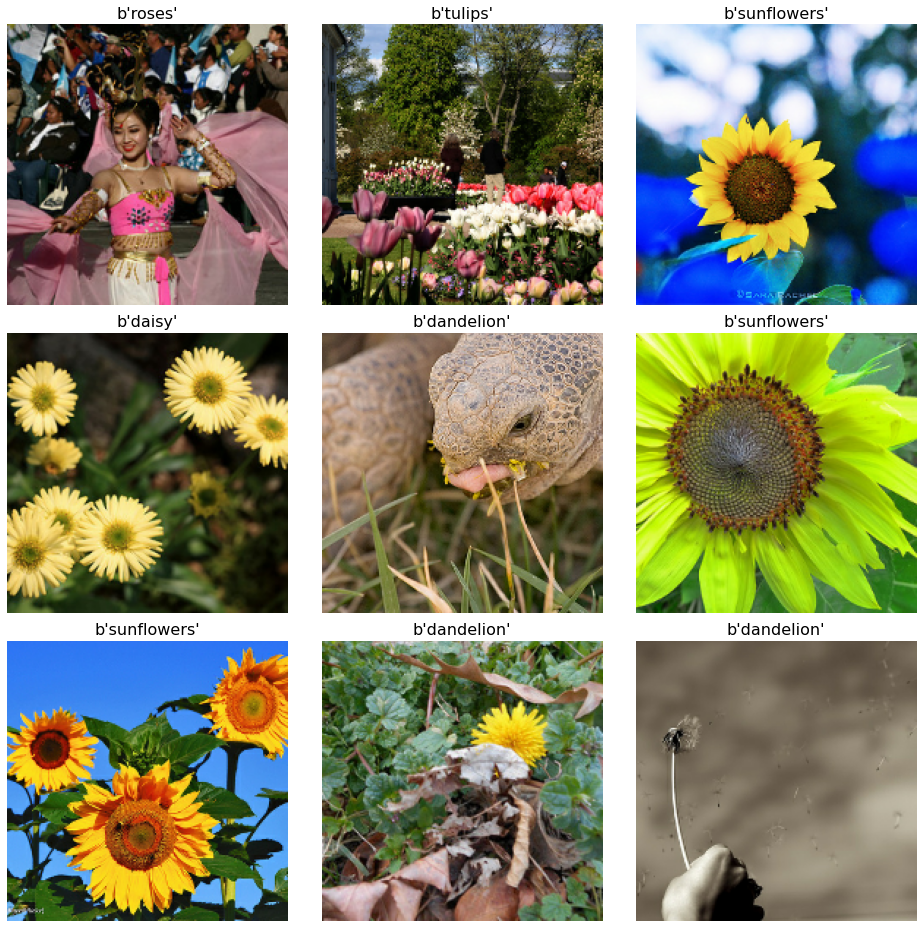

In [ ]:
display_9_images_from_dataset(dsetResized)

Now, let's test continuous reading from the dataset. We can see that reading the first 100 files already takes some time.

In [ ]:
sample_set = dsetResized.batch(10).take(10) # take 10 batches of 10 images for testing
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['sunflowers', 'tulips', 'sunflowers', 'tulips', 'dandelion', 'tulips', 'tulips', 'sunflowers', 'dandelion', 'tulips'])
Image batch shape (10, 192, 192, 3), ['tulips', 'dandelion', 'roses', 'dandelion', 'tulips', 'sunflowers', 'roses', 'sunflowers', 'sunflowers', 'daisy'])
Image batch shape (10, 192, 192, 3), ['roses', 'roses', 'daisy', 'dandelion', 'dandelion', 'roses', 'sunflowers', 'tulips', 'tulips', 'tulips'])
Image batch shape (10, 192, 192, 3), ['daisy', 'daisy', 'dandelion', 'tulips', 'tulips', 'daisy', 'tulips', 'dandelion', 'dandelion', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['daisy', 'daisy', 'dandelion', 'sunflowers', 'daisy', 'sunflowers', 'tulips', 'daisy', 'sunflowers', 'daisy'])
Image batch shape (10, 192, 192, 3), ['daisy', 'dandelion', 'sunflowers', 'sunflowers', 'sunflowers', 'tulips', 'roses', 'tulips', 'sunflowers', 'tulips'])
Image batch shape (10, 192, 192, 3), ['tulips', 'daisy', 'sunflowers', 'dandelion', 'tulip

## 1.2 Improving Speed 

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size. 
This **costs some CPU time**, but **saves network and disk bandwith**, especially when the data are **read multiple times**. 


In [ ]:
# This is a quick test to get an idea how long recompressions takes.  
dataset4 = dsetResized.map(recompress_image)
test_set = dataset4.batch(10).take(10)
for image, label in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()])) 

Image batch shape (10,), ['daisy', 'tulips', 'tulips', 'sunflowers', 'daisy', 'dandelion', 'roses', 'sunflowers', 'roses', 'roses'])
Image batch shape (10,), ['daisy', 'dandelion', 'daisy', 'sunflowers', 'sunflowers', 'sunflowers', 'dandelion', 'dandelion', 'tulips', 'daisy'])
Image batch shape (10,), ['roses', 'dandelion', 'tulips', 'dandelion', 'sunflowers', 'tulips', 'tulips', 'daisy', 'daisy', 'sunflowers'])
Image batch shape (10,), ['roses', 'tulips', 'dandelion', 'sunflowers', 'dandelion', 'dandelion', 'roses', 'roses', 'dandelion', 'sunflowers'])
Image batch shape (10,), ['roses', 'dandelion', 'sunflowers', 'dandelion', 'sunflowers', 'dandelion', 'sunflowers', 'sunflowers', 'tulips', 'dandelion'])
Image batch shape (10,), ['tulips', 'daisy', 'dandelion', 'sunflowers', 'sunflowers', 'roses', 'sunflowers', 'tulips', 'dandelion', 'tulips'])
Image batch shape (10,), ['sunflowers', 'tulips', 'sunflowers', 'roses', 'dandelion', 'roses', 'dandelion', 'dandelion', 'daisy', 'sunflowers']

In [ ]:
type(dataset4)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [ ]:
list(dataset4.as_numpy_iterator())[:2] # This returns a list of tuples. Each tuple contains an compressed image and a label as string. So, this can be parallelised into an RDD.

[(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00\xc0\x00\xc0\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1e\x00\x00\x01\x05\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x07\x04\x05\x06\x08\t\x03\x02\n\x01\x00\xff\xc4\x00C\x10\x00\x01\x03\x03\x03\x03\x03\x02\x04\x05\x01\x06\x03\x08\x03\x00\x01\x02\x03\x04\x05\x06\x11\x00\x07!\x08\x121\x13"A\tQ\x142aq\x15#B\x81\x91R\x16\x17$Cb\xa1\xb1\xc1\xd1\n\x18%&Sr\x82\x923\x94\xf1\xff\xc4\x00\x1c\x01\x00\x01\x05\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x02\x03\x04\x06

### Write the dataset to TFRecord files

By writing **multiple preprocessed samples into a single file**, we can make further speed gains. 
We distribute the data over **partitions** to facilitate **parallelisation** when the data are used. 
First we need to **define a location** where we want to put the file. 

In [ ]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket. 

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. For convenience I have commented out the call to `write_tfrecords` at the end of the next cell. You don't need to run it (it takes some time), but you'll need to use the code below later.Again, you don't need to study the first three functions' internals, only the `write_tfrecord` function is relevant.  

There are **ready-made pre-processed data** versions available, e.g. here: 
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for comparison and later use. 

In [ ]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,        # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size):
    print("Writing TFRecords")
    tt0 = time.time()
    filenames = tf.data.Dataset.list_files(GCS_PATTERN) 
    dataset1 = filenames.map(decode_jpeg_and_label)
    dataset2 = dataset1.map(resize_and_crop_image)  
    dataset3 = dataset2.map(recompress_image)
    dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file 
    for partition, (image, label) in enumerate(dataset4):
        # batch size used as partition size here
        partition_size = image.numpy().shape[0]
        # good practice to have the number of records in the filename
        filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files  
        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(partition_size):
                example = to_tfrecord(out_file,
                                    image.numpy()[i], # re-compressed image: already a byte string
                                    label.numpy()[i] #
                                    )
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, partition_size))
    print("Total time: "+str(time.time()-tt0))

write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size) # uncomment to run this cell

Writing TFRecords
Wrote file gs://astral-sunbeam-344511-storage/tfrecords-jpeg-192x192-2/flowers00-230.tfrec containing 230 records
Wrote file gs://astral-sunbeam-344511-storage/tfrecords-jpeg-192x192-2/flowers01-230.tfrec containing 230 records
Wrote file gs://astral-sunbeam-344511-storage/tfrecords-jpeg-192x192-2/flowers02-230.tfrec containing 230 records
Wrote file gs://astral-sunbeam-344511-storage/tfrecords-jpeg-192x192-2/flowers03-230.tfrec containing 230 records
Wrote file gs://astral-sunbeam-344511-storage/tfrecords-jpeg-192x192-2/flowers04-230.tfrec containing 230 records
Wrote file gs://astral-sunbeam-344511-storage/tfrecords-jpeg-192x192-2/flowers05-230.tfrec containing 230 records
Wrote file gs://astral-sunbeam-344511-storage/tfrecords-jpeg-192x192-2/flowers06-230.tfrec containing 230 records
Wrote file gs://astral-sunbeam-344511-storage/tfrecords-jpeg-192x192-2/flowers07-230.tfrec containing 230 records
Wrote file gs://astral-sunbeam-344511-storage/tfrecords-jpeg-192x192-2

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above. These functions are for demonstration only, you don't need to study these.

In [ ]:
  # GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' 
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

Let's have a look **if reading from the TFRecord** files is **quicker**. 

In [ ]:
batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['3', '4', '1', '2', '4', '0', '4', '4', '4', '3'])
Image batch shape (10, 192, 192, 3), ['4', '3', '2', '0', '2', '3', '0', '4', '2', '2'])
Image batch shape (10, 192, 192, 3), ['3', '0', '1', '4', '0', '1', '0', '4', '3', '3'])
Image batch shape (10, 192, 192, 3), ['0', '0', '3', '2', '2', '0', '1', '3', '1', '0'])
Image batch shape (10, 192, 192, 3), ['2', '3', '4', '4', '1', '4', '3', '4', '1', '2'])
Image batch shape (10, 192, 192, 3), ['3', '1', '3', '4', '2', '0', '0', '3', '3', '0'])
Image batch shape (10, 192, 192, 3), ['2', '4', '2', '1', '0', '3', '1', '3', '3', '0'])
Image batch shape (10, 192, 192, 3), ['1', '2', '4', '4', '1', '1', '4', '3', '3', '1'])
Image batch shape (10, 192, 192, 3), ['4', '1', '3', '3', '4', '1', '3', '2', '3', '2'])
Image batch shape (10, 192, 192, 3), ['1', '0', '3', '4', '4', '2', '1', '4', '1', '3'])


Wow, we have a **massive speed-up**! The repackageing is worthwhile :-)

In [ ]:
type(batched_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
list(batched_dataset.as_numpy_iterator())[:2]; # This returns a list of tuples. The tuple contains arrays of images and array of encoded labels.

## Task 1: Write TFRecord files to the cloud with Spark (30%)

Since recompressing and repackaging is effective, we would like to be able to do it inparallel for large datasets. 
This is a relatively straightforward case of parallelisation. 
We will again Spark to implement the same process as above, but in parallel.

### 1a)	Create the script (10%)

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over multiple machines**. 

You need to: 

i) **Copy** over the **mapping functions** (see section 1.1) and **adapt** the resizing and recompression function **to Spark** (only one argument). (2%)

ii) **Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames. (2%)

iii) **Sample** the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests. (1%)

iv) Then **use the functions from above** to write the TFRecord files, using an RDD as the vehicle for parallelisation but not for storing the image data. (2%)

v) The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/2.4.8/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function. 
The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files. (3%) 


In [ ]:
### START OF ANSWER to TASK 1a ###

In [ ]:
imgfls_rdd = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN))

In [ ]:
imgfls_rdd.getNumPartitions() # check how many partitions are assigned by default

2

In [ ]:
imgfls_rdd.take(3) # have a glance of the RDD

['gs://flowers-public/daisy/100080576_f52e8ee070_n.jpg',
 'gs://flowers-public/daisy/10140303196_b88d3d6cec.jpg',
 'gs://flowers-public/daisy/10172379554_b296050f82_n.jpg']

In [ ]:
imgfls_rdd.count() # check if all the data is parallelized

3670

RDD sampling coding reference:
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.sample.html

In [ ]:
imgfls_sample_rdd = imgfls_rdd.sample(False, 0.02) # creating small sample set of RDD instead of full set.

In [ ]:
imgfls_sample_rdd.take(2)

['gs://flowers-public/daisy/100080576_f52e8ee070_n.jpg',
 'gs://flowers-public/daisy/13583238844_573df2de8e_m.jpg']

In [ ]:
imgfls_sample_rdd.count()

77

In [ ]:
# adapting original function for spark

def decode_jpeg_and_label_rdd(inp_rdd):
    # extracts the image data and creates a class label, based on the filepath 
    bits = tf.io.read_file(inp_rdd) # Note: This operation returns a tensor with the entire contents of the input filename. 
    # It does not do any parsing, it just returns the contents as they are, as a tensor of dtype "string", with the file contents.
    
    image = tf.image.decode_jpeg(bits) # Note: Decode a JPEG-encoded image to a Tensor of type uint8.
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(inp_rdd, axis=-1), sep='/')
    # tf.expand_dims(filepath, axis=-1) would transform the filepath into a Tensor of n dimensional array consisting of only
    # column vectors, as experimented last few cells above. tf.strings.split with argument sep='/' would seperated the contents of 
    # file path Tensor wherever there is a '/' and create a ReggedTensor
    
    label2 = label.values[-2] # would re
    return image, label2

In [ ]:
decoded_sample_rdd = imgfls_sample_rdd.map(decode_jpeg_and_label_rdd) # mapping the adapted function

In [ ]:
# adapting original function for spark

def resize_and_crop_image_rdd(decinp_rdd):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    image, label = decinp_rdd
    
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

In [ ]:
resized_sample_rdd = decoded_sample_rdd.map(resize_and_crop_image_rdd) # mapping the adapted function

In [ ]:
# adapting original function for spark

def recompress_image_rdd(reszinp_rdd):
    # this reduces the amount of data, but takes some time
    image, label = reszinp_rdd
    
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

In [ ]:
recompressed_rdd = resized_sample_rdd.map(recompress_image_rdd) # mapping the adapted function

In [ ]:
recompressed_rdd.take(2) # cross check if the elements look like unparallelized version

[(<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00\xc0\x00\xc0\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x03\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x06\x07\x03\x02\x01\x08\x00\xff\xc4\x00D\x10\x00\x02\x01\x03\x03\x03\x02\x03\x04\x08\x03\x06\x05\x05\x01\x00\x01\x02\x03\x04\x05\x11\x00\x06\x12\x07!1\x13A"Qa\x142q\x81\x08\x15#BRb\x91\xa1\x16\xb1\xc1\x173r\x82\xd1\xe1CS\x92\xb2\xf0\t$4c\xc2\xf1\xff\xc4\x00\x1c\x01\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00

In [ ]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,        # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords_rdd(index,iterator):
    filename = GCS_OUTPUT + "{:02d}.tfrec".format(index)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files  
    with tf.io.TFRecordWriter(filename) as out_file:
      for (image, label) in iterator:
        example = to_tfrecord(out_file,
                                image.numpy(), # re-compressed image: already a byte string
                                label.numpy() #
                                )
        out_file.write(example.SerializeToString())
        # print("Wrote file {} containing {} records".format(filename, partition_size))
    return [filename]


In [ ]:
# create partitions with addition of index values of respective partition.

tt0 = time.time()
ind_fln_rdd = recompressed_rdd.mapPartitionsWithIndex(write_tfrecords_rdd)
print("Total time: "+str(time.time()-tt0))

Total time: 0.0002651214599609375


In [ ]:
ind_fln_rdd.take(3)

['gs://astral-sunbeam-344511-storage/tfrecords-jpeg-192x192-2/flowers00.tfrec',
 'gs://astral-sunbeam-344511-storage/tfrecords-jpeg-192x192-2/flowers01.tfrec']

In [ ]:
ind_fln_rdd.collect()

['gs://astral-sunbeam-344511-storage/tfrecords-jpeg-192x192-2/flowers00.tfrec',
 'gs://astral-sunbeam-344511-storage/tfrecords-jpeg-192x192-2/flowers01.tfrec']

In [ ]:
### END OF ANSWER to TASK 1a ###


### 1b)	Testing (2%)

i) Read from the TFRecord Dataset, using `display_9_images_from_dataset` to test. 


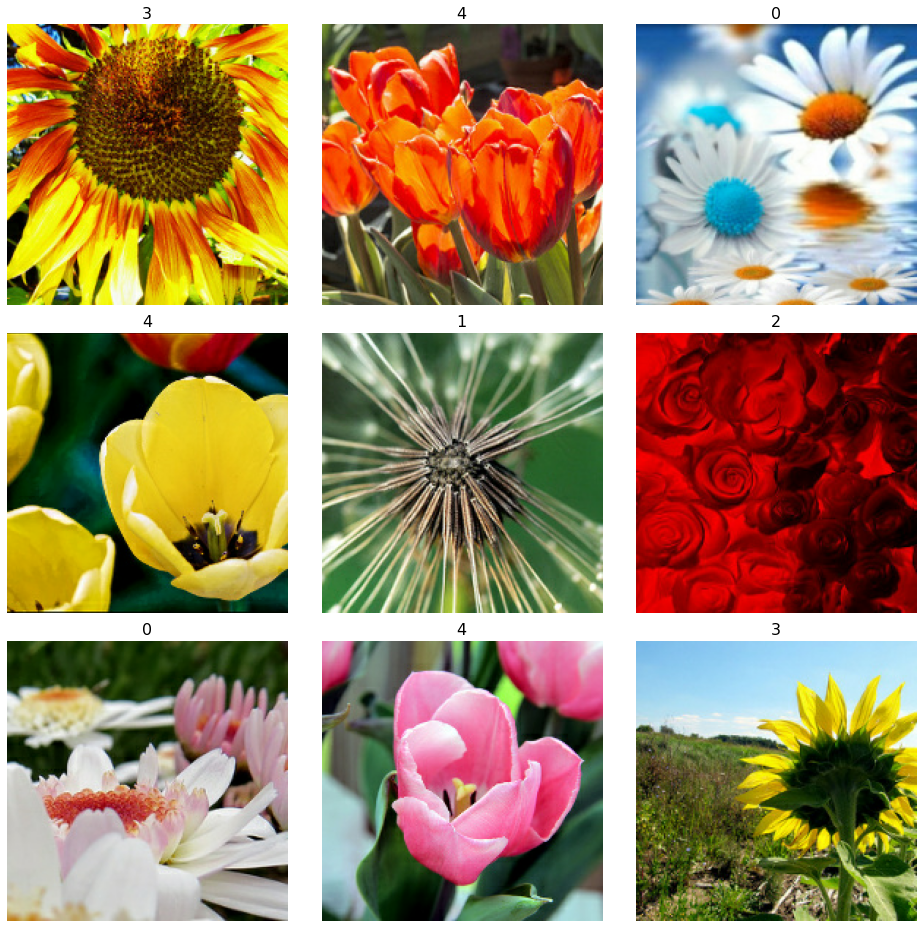

In [ ]:
### TASK 1b (i) ###

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

    
filenames1 = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec1 = load_dataset(filenames1)


display_9_images_from_dataset(datasetTfrec)

ii) Write your code it into a file using the *cell magic* `%%writefile spark_write_tfrec.py` at the beginning of the file. Then, run it locally in Spark. 



In [ ]:
### TASK 1b (ii) ###
%%writefile task_1b_2_script.py

import os, sys, math
import numpy as np
# import scipy as sp
# import scipy.stats
import time
import datetime
import string
import random
# from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import pyspark

sc = pyspark.SparkContext.getOrCreate()
print(sc)



def decode_jpeg_and_label_rdd(inp_rdd):
    # extracts the image data and creates a class label, based on the filepath 
    bits = tf.io.read_file(inp_rdd) # Note: This operation returns a tensor with the entire contents of the input filename. 
    # It does not do any parsing, it just returns the contents as they are, as a tensor of dtype "string", with the file contents.
    
    image = tf.image.decode_jpeg(bits) # Note: Decode a JPEG-encoded image to a Tensor of type uint8.
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(inp_rdd, axis=-1), sep='/')
    # tf.expand_dims(filepath, axis=-1) would transform the filepath into a Tensor of n dimensional array consisting of only
    # column vectors, as experimented last few cells above. tf.strings.split with argument sep='/' would seperated the contents of 
    # file path Tensor wherever there is a '/' and create a ReggedTensor
    
    label2 = label.values[-2] # would re
    return image, label2


def resize_and_crop_image_rdd(decinp_rdd):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    image, label = decinp_rdd
    
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label


def recompress_image_rdd(reszinp_rdd):
    # this reduces the amount of data, but takes some time
    image, label = reszinp_rdd
    
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label


# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,        # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords_rdd(index,iterator):
    filename = GCS_OUTPUT + "{:02d}.tfrec".format(index)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files  
    with tf.io.TFRecordWriter(filename) as out_file:
      for (image, label) in iterator:
        example = to_tfrecord(out_file,
                                image.numpy(), # re-compressed image: already a byte string
                                label.numpy() #
                                )
        out_file.write(example.SerializeToString())
        # print("Wrote file {} containing {} records".format(filename, partition_size))
    return [filename]


GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)


PROJECT = 'astral-sunbeam-344511'

BUCKET = 'gs://{}-storage'.format(PROJECT)

GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names



if __name__ == "__main__" : # defining manual execution of code.
    print("Writing TFRecords")

tt0 = time.time()
imgfls_rdd = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN))
imgfls_sample_rdd = imgfls_rdd.sample(False, 0.02)
decoded_sample_rdd = imgfls_sample_rdd.map(decode_jpeg_and_label_rdd)
resized_sample_rdd = decoded_sample_rdd.map(resize_and_crop_image_rdd)
recompressed_rdd = resized_sample_rdd.map(recompress_image_rdd)
ind_fln_rdd = recompressed_rdd.mapPartitionsWithIndex(write_tfrecords_rdd)
print("ind_fln_rdd.collect(): " + str(ind_fln_rdd.collect()))
print("Total time: "+str(time.time()-tt0))


Overwriting task_1b_2_script.py


### 1c) Set up a cluster and run the script. (4%)

Following the example from the labs, set up a cluster to run PySpark jobs in the cloud. You need to set up so that TensorFlow is installed on all nodes in the cluster.  


#### i) Single machine cluster
Set up a cluster with a single machine using the maximal SSD size (100) and 8 vCPUs. 

Enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install). 
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.4.0`. 

When the cluster is sunning, run your script to check that it works and keep the output cell output. (2%)


In [ ]:
### TASK 1c (i) ###
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.5-ubuntu18 --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0

Waiting on operation [projects/astral-sunbeam-344511/regions/us-central1/operations/081eb874-2687-3e80-ad36-0b9ff26d4c31].
Created [https://dataproc.googleapis.com/v1/projects/astral-sunbeam-344511/regions/us-central1/clusters/astral-sunbeam-344511-cluster] Cluster placed in zone [us-central1-f].


Run the script in the cloud and test the output. 

In [ ]:
### TASK 1c (i) ###
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./task_1b_2_script.py 

Job [d63a0e818aa94881939af724d7a6b9e5] submitted.
Waiting for job output...
2022-05-01 21:59:18.620275: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-01 21:59:18.620327: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
22/05/01 21:59:21 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/01 21:59:21 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/01 21:59:21 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/01 21:59:22 INFO org.spark_project.jetty.util.log: Logging initialized @5997ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/01 21:59:22 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built

Code to **delete the cluster**, as it incurs a cost for the time it runs. 

In [ ]:
# !gcloud dataproc clusters delete $CLUSTER -q  # uncomment first line is cluster is to be deleted from colab.
# the -q flag disables the confirmation prompt 
# , we want to make sure it really gets deleted

In the free credit tier on Google Cloud, there are the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk* 
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details 
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.  


#### ii) Maximal cluster
Use the **largest possible cluster** within these constraints, i.e. **1 master and 7 worker nodes**. 
Each of them with 1 (virtual) CPU. 
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput. 

Once the cluster is running, test your script. (2%)

In [ ]:
### TASK 1c (ii) ###

CLUSTER = '{}-cluster'.format(PROJECT)

!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 7 \
    --worker-machine-type n1-standard-1 \
    --worker-boot-disk-type pd-standard --worker-boot-disk-size 285 \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0

Waiting on operation [projects/astral-sunbeam-344511/regions/us-central1/operations/84b20e08-e2d8-3741-9f88-5252fa193a34].

Created [https://dataproc.googleapis.com/v1/projects/astral-sunbeam-344511/regions/us-central1/clusters/astral-sunbeam-344511-cluster] Cluster placed in zone [us-central1-a].


In [ ]:
### TASK 1c (ii) ###

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./task_1b_2_script.py 

Job [330d2b4c72874da6ab2650ce5cc87c02] submitted.
Waiting for job output...
2022-05-01 19:59:59.182711: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-01 19:59:59.182882: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
22/05/01 20:00:04 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/01 20:00:04 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/01 20:00:04 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/01 20:00:04 INFO org.spark_project.jetty.util.log: Logging initialized @10728ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/01 20:00:04 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; buil

Code to **delete the cluster**, as it incurs a cost for the time it runs. 

In [ ]:
# !gcloud dataproc clusters delete $CLUSTER -q # uncomment first line is cluster is to be deleted from colab.
# the -q flag disables the confirmation prompt 
# , we want to make sure it really gets deleted

### 1d)	Optimisation, experiments, and discussion (14%)

i) Improve parallelisation 

If you implemented a straightfoward version, you will 
**probably** observe that **all the computation** is done on only **two nodes**. 
This can be adressed by using the **second parameter** in the initial call to **parallelize**. 
Make the **suitable change** in the code you have written above and mark it up in comments as `### TASK 1d ###`. 

Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with **screenshots from Google Cloud** and measure the **difference in the processing time**. (5%)

ii) Experiment with cluster configurations.

In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources. 
Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (6%)

iii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here? (3%)

Write the code below and your answers in the report.


In [ ]:
### TASK 1d ###
%%writefile task_1d_1_script.py

import os, sys, math
import numpy as np
# import scipy as sp
# import scipy.stats
import time
import datetime
import string
import random
# from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import pyspark

sc = pyspark.SparkContext.getOrCreate()
print(sc)



def decode_jpeg_and_label_rdd(inp_rdd):
    # extracts the image data and creates a class label, based on the filepath 
    bits = tf.io.read_file(inp_rdd) # Note: This operation returns a tensor with the entire contents of the input filename. 
    # It does not do any parsing, it just returns the contents as they are, as a tensor of dtype "string", with the file contents.
    
    image = tf.image.decode_jpeg(bits) # Note: Decode a JPEG-encoded image to a Tensor of type uint8.
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(inp_rdd, axis=-1), sep='/')
    # tf.expand_dims(filepath, axis=-1) would transform the filepath into a Tensor of n dimensional array consisting of only
    # column vectors, as experimented last few cells above. tf.strings.split with argument sep='/' would seperated the contents of 
    # file path Tensor wherever there is a '/' and create a ReggedTensor
    
    label2 = label.values[-2] # would re
    return image, label2


def resize_and_crop_image_rdd(decinp_rdd):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    image, label = decinp_rdd
    
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label


def recompress_image_rdd(reszinp_rdd):
    # this reduces the amount of data, but takes some time
    image, label = reszinp_rdd
    
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label


# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,        # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords_rdd(index,iterator):
    filename = GCS_OUTPUT + "{:02d}.tfrec".format(index)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files  
    with tf.io.TFRecordWriter(filename) as out_file:
      for (image, label) in iterator:
        example = to_tfrecord(out_file,
                                image.numpy(), # re-compressed image: already a byte string
                                label.numpy() #
                                )
        out_file.write(example.SerializeToString())
        # print("Wrote file {} containing {} records".format(filename, partition_size))
    return [filename]


GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)


PROJECT = 'astral-sunbeam-344511'

BUCKET = 'gs://{}-storage'.format(PROJECT)

GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names



if __name__ == "__main__" : # defining manual execution of code.
    print("Writing TFRecords")

tt0 = time.time()
imgfls_rdd = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN), PARTITIONS)
imgfls_sample_rdd = imgfls_rdd.sample(False, 0.02)
decoded_sample_rdd = imgfls_sample_rdd.map(decode_jpeg_and_label_rdd)
resized_sample_rdd = decoded_sample_rdd.map(resize_and_crop_image_rdd)
recompressed_rdd = resized_sample_rdd.map(recompress_image_rdd)
repart_rdd = recompressed_rdd.repartition(PARTITIONS)
ind_fln_rdd = repart_rdd.mapPartitionsWithIndex(write_tfrecords_rdd)
print("ind_fln_rdd.collect(): " + str(ind_fln_rdd.collect()))
print("Total time: "+str(time.time()-tt0))


Writing task_1d_1_script.py


** 1 Master + 7 Workers**

In [ ]:
CLUSTER = '{}-cluster'.format(PROJECT)

!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 7 \
    --worker-machine-type n1-standard-1 \
    --worker-boot-disk-type pd-standard --worker-boot-disk-size 285 \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0

Waiting on operation [projects/astral-sunbeam-344511/regions/us-central1/operations/f2225739-7206-3275-899e-8689835fa1aa].

Created [https://dataproc.googleapis.com/v1/projects/astral-sunbeam-344511/regions/us-central1/clusters/astral-sunbeam-344511-cluster] Cluster placed in zone [us-central1-a].


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./task_1d_1_script.py 

Job [5e60d0f44dd2451fb02666613d3ce733] submitted.
Waiting for job output...
2022-05-01 23:44:21.697558: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-01 23:44:21.697724: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
22/05/01 23:44:26 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/01 23:44:26 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/01 23:44:26 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/01 23:44:26 INFO org.spark_project.jetty.util.log: Logging initialized @10333ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/01 23:44:27 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; buil

**1d)**
  **ii)**

**1 Master + 3 Workers Configuration with 2vCPUs for all.**

In [ ]:
CLUSTER = '{}-cluster'.format(PROJECT)

!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 3 \
    --worker-machine-type n1-standard-2 \
    --worker-boot-disk-type pd-standard --worker-boot-disk-size 100 \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0

Waiting on operation [projects/astral-sunbeam-344511/regions/us-central1/operations/3e62fec1-b26c-3b65-a1e6-bd4a2da0952f].

Created [https://dataproc.googleapis.com/v1/projects/astral-sunbeam-344511/regions/us-central1/clusters/astral-sunbeam-344511-cluster] Cluster placed in zone [us-central1-f].


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./task_1d_1_script.py 

Job [767a25ec546e4f7fa43556fc71700ade] submitted.
Waiting for job output...
2022-05-02 13:32:32.678909: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-02 13:32:32.678960: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
22/05/02 13:32:36 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/02 13:32:36 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/02 13:32:36 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/02 13:32:37 INFO org.spark_project.jetty.util.log: Logging initialized @7753ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/02 13:32:37 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built

**1 Master with 8 vCPUs Configuration**



In [ ]:
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.5-ubuntu18 --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0

Waiting on operation [projects/astral-sunbeam-344511/regions/us-central1/operations/5869e442-dd0f-3612-b7b7-a0f319963af7].
Created [https://dataproc.googleapis.com/v1/projects/astral-sunbeam-344511/regions/us-central1/clusters/astral-sunbeam-344511-cluster] Cluster placed in zone [us-central1-f].


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./task_1d_1_script.py 

Job [90f6d07e8b154cc39d382efb67057a03] submitted.
Waiting for job output...
2022-05-02 14:09:02.015079: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-02 14:09:02.015128: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
22/05/02 14:09:05 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/02 14:09:05 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/02 14:09:05 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/02 14:09:05 INFO org.spark_project.jetty.util.log: Logging initialized @5900ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/02 14:09:05 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built

# Section 2: Speed tests

We have seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly. 
This task is about **measuring this effect** and **parallelizing the tests with PySpark**. 

## 2.1 Speed test implementation 

Here is **code for time measurement** to determine the **throughput in images per second**. 
It doesn't render the images but extracts and prints some basic information in order to make sure the image data are read. 
We write the information to the null device for longer measurements `null_file=open("/dev/null", mode='w')`. 
That way it will not clutter our cell output.

We use batches ( `dset2 = dset1.batch(batch_size)` ) and select a number of batches with (`dset3 = dset2.take(batch_number)`). 
Then we  use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset to see if reading speed changes with mutiple readings. 

We then **vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**. 
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be combined in a **function** `time_configs()` that takes a configuration, i.e. a dataset and arrays of `batch_sizes`, `batch_numbers`, and  `repetitions` (an array of integers starting from 1), as **arguments** and runs the time measurement for each combination of batch_size and batch_number for the requested number of repetitions. 

In [ ]:
# Here are some useful values for testing your code, use higher values later for actually testing throughput
batch_sizes = [2,4] 
batch_numbers = [3,6] 
repetitions = [1]

def time_configs(dataset, batch_sizes, batch_numbers, repetitions): 
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)] 
    print(dims) 
    results = np.zeros(dims) 
    params = np.zeros(dims + [3]) 
    print( results.shape ) 
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking 
        for bsi,bs in enumerate(batch_sizes): 
            for dsi, ds in enumerate(batch_numbers): 
                batched_dataset = dataset.batch(bs)  
                timing_set = batched_dataset.take(ds) 
                for ri,rep in enumerate(repetitions): 
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep)) 
                    t0 = time.time() 
                    for image, label in timing_set: 
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape, 
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td 
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params

**Let's try this function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset2) and the TFRecord files (datasetDecoded). 

In [ ]:
### CODING TASK
[res,par] = time_configs(dataset4, [3, 7], [7, 3], [4])
print(res) 
print(par) 

print("=============")

[res,par] = time_configs(datasetTfrec, [4, 6], [6, 4], [3])
print(res)
print(par)

[2, 2, 1]
(2, 2, 1)
bs: 3, ds: 7, rep: 4
Image batch shape (3,), ["b'sunflowers'", "b'daisy'", "b'roses'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (3,), ["b'dandelion'", "b'daisy'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (3,), ["b'daisy'", "b'dandelion'", "b'roses'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (3,), ["b'sunflowers'", "b'daisy'", "b'roses'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (3,), ["b'daisy'", "b'sunflowers'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (3,), ["b'dandelion'", "b'roses'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (3,), ["b'roses'", "b'daisy'", "b'daisy'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
bs: 3, ds: 3, rep: 4
Image batch shape (3,), ["b'da

## Task 2: Parallelising the speed test with Spark in the cloud. (30%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark. 
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later). 


### 2a) Create the script (12%)
Your task is now to **port the speed test above to Spark** for running it in the cloud in Dataproc. 
**Adapt the speed testing** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**. 
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically: 
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (1%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%) 
*   vi) write the results to a pickle file in your bucket (1%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [ ]:
### CODING for TASK 2a (i) to (vi) ###

import os, sys, math
import numpy as np
# import scipy as sp
# import scipy.stats
import time
import datetime
import string
import random
# from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse


GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

PROJECT = 'astral-sunbeam-344511'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'


def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath 
    bits = tf.io.read_file(filepath) # Note: This operation returns a tensor with the entire contents of the input filename. 
    # It does not do any parsing, it just returns the contents as they are, as a tensor of dtype "string", with the file contents.
    
    image = tf.image.decode_jpeg(bits) # Note: Decode a JPEG-encoded image to a Tensor of type uint8.
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    # tf.expand_dims(filepath, axis=-1) would transform the filepath into a Tensor of n dimensional array consisting of only
    # column vectors, as experimented last few cells above. tf.strings.split with argument sep='/' would seperated the contents of 
    # file path Tensor wherever there is a '/' and create a ReggedTensor
    
    label2 = label.values[-2] # would re
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

# create a function to load image data, that is based on the above function
def image_dataset_load():
    dataset_fln_list = tf.data.Dataset.list_files(GCS_PATTERN) #Image Files
    dataset_decoded = dataset_fln_list.map(decode_jpeg_and_label)
    dataset_rszcrp = dataset_decoded.map(resize_and_crop_image)
    return dataset_rszcrp

# create a function to calcualte throughput of TFR for different parameter combinations
def tfr_reading_speed(param):
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    dataset = load_dataset(filenames)
    
    time_test_data = []
    
    size = param[0]
    number = param[1]
    reps = param[2]
    
    batch = dataset.batch(size)
    sample = dataset.take(number)
    
    for rep in range(reps):
      t_start = time.time()
      for picture in sample:
        print('string', file=open("/dev/null", mode='w'))
      t_end = time.time()
      reading_speed = t_end - t_start
      throughput = float((size * number) / (t_end - t_start))
      time_test_data.append([size, number, (size * number), reps, reading_speed, throughput])
    return time_test_data

# create a function to calcualte throughput of image for different parameter combinations
def image_reading_speed(param):
    dataset = image_dataset_load()
    time_test_data_image = []
    
    size = param[0]
    number = param[1]
    reps = param[2]
    
    batch = dataset.batch(size)
    sample = dataset.take(number)
    
    for rep in range(reps):
      t_start = time.time()
      for picture in sample:
        print('string', file=open("/dev/null", mode='w'))
      t_end = time.time()
      reading_speed = t_end - t_start
      throughput = float((size * number) / (t_end - t_start))
      time_test_data_image.append([size, number, (size * number), reps, reading_speed, throughput])
    return time_test_data_image

# create a function to save the data after all the processing
def save(object, bucket, filename):
    with open(filename,mode='ab') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

# create a function that will parallelize the throughputs calucalted and categorise those for different parameters
# and then calculate their average values
def check_speed(argv): #task_testing
    # Parse the provided arguments
    
    parser = argparse.ArgumentParser() # get a parser object
    
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv)

    batch_sizes = [16, 32, 64, 128]
    batch_numbers = [10, 20, 30]
    repetitions = [1, 2, 3]

    param = []

    for size in batch_sizes:
      for number in batch_numbers:
        for reps in repetitions:
          param.append([size, number, reps])
    
    

    from pyspark import sql
    from pyspark.sql import SparkSession
    from pyspark.sql import SQLContext
    from pyspark.sql import Row


    column_names = ["batch_size", "batch_numbers", "datasize", "repititions", "reading_speed", "throughput"]
    sc_tfr = pyspark.SparkContext.getOrCreate()
    rdd_tf = sc_tfr.parallelize(param) # creating rdd for TFR
    results_tf = rdd_tf.flatMap(tfr_reading_speed) # mapping the RDD to create list of lists
    spark_tfdf = SparkSession(sc_tfr) # spark session to convert result into spark dataframe
    result_tfdf = results_tf.toDF(column_names) # transformation into dataframe

  
    sc_image = pyspark.SparkContext.getOrCreate()
    rdd_image = sc_image.parallelize(param) # creating rdd for image
    results_image = rdd_image.flatMap(tfr_reading_speed) # mapping the RDD to create list of lists
    spark_imgdf = SparkSession(sc_image) # spark session to convert result into spark dataframe
    result_imgdf = results_image.toDF(column_names) # transformation into dataframe
  


  # creating RDDs of throughput of TFR for individual parameters
    tfr_sz_thrpt_rdd = result_tfdf.rdd.map(lambda x: (int(x['batch_size']), float(x['throughput'])))
    tfr_sz_thrpt_c = tfr_sz_thrpt_rdd.collect()
    tfr_num_thrpt_rdd = result_tfdf.rdd.map(lambda x: (int(x['batch_numbers']), float(x['throughput'])))
    tfr_num_thrpt_c = tfr_num_thrpt_rdd.collect()
    tfr_dsz_thrpt_rdd = result_tfdf.rdd.map(lambda x: (int(x['datasize']), float(x['throughput'])))
    tfr_dsz_thrpt_c = tfr_dsz_thrpt_rdd.collect()
    tfr_rep_thrpt_rdd = result_tfdf.rdd.map(lambda x: (int(x['repititions']), float(x['throughput'])))
    tfr_rep_thrpt_c = tfr_rep_thrpt_rdd.collect()


 # creating RDDs of throughput of image for individual parameters
    image_sz_thrpt_rdd = result_imgdf.rdd.map(lambda x: (int(x['batch_size']), float(x['throughput'])))
    image_sz_thrpt_c = image_sz_thrpt_rdd.collect()
    image_num_thrpt_rdd = result_imgdf.rdd.map(lambda x: (int(x['batch_numbers']), float(x['throughput'])))
    image_num_thrpt_c = image_num_thrpt_rdd.collect()
    image_dsz_thrpt_rdd = result_imgdf.rdd.map(lambda x: (int(x['datasize']), float(x['throughput'])))
    image_dsz_thrpt_c = image_dsz_thrpt_rdd.collect()
    image_rep_thrpt_rdd = result_imgdf.rdd.map(lambda x: (int(x['repititions']), float(x['throughput'])))
    image_rep_thrpt_c = image_rep_thrpt_rdd.collect()


 # creating RDDs of average throughput of TFR for individual parameters
    tfr_sz_thrpt_avg_rdd = tfr_sz_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    tfr_sz_thrpt_avg_c = tfr_sz_thrpt_avg_rdd.collect()
    tfr_num_thrpt_avg_rdd = tfr_num_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    tfr_num_thrpt_avg_c = tfr_num_thrpt_avg_rdd.collect()
    tfr_dsz_thrpt_avg_rdd = tfr_dsz_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    tfr_dsz_thrpt_avg_c = tfr_dsz_thrpt_avg_rdd.collect()
    tfr_rep_thrpt_avg_rdd = tfr_rep_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    tfr_rep_thrpt_avg_c = tfr_rep_thrpt_avg_rdd.collect()


 # creating RDDs of average throughput of image for individual parameters
    image_sz_thrpt_avg_rdd = image_sz_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    iamge_sz_thprt_avg_c = image_sz_thrpt_avg_rdd.collect()
    image_num_thrpt_avg_rdd = image_num_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    image_num_thrpt_avg_c = image_num_thrpt_avg_rdd.collect()
    image_dsz_thrpt_avg_rdd = image_dsz_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    image_dsz_thrpt_avg_c = image_dsz_thrpt_avg_rdd.collect()
    image_rep_thrpt_avg_rdd = image_rep_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    image_rep_thrpt_avg_c = image_rep_thrpt_avg_rdd.collect()


# create a tuple of all the RDDs of throughput and average throughput created above
    save_object = (
        tfr_sz_thrpt_c,
        tfr_num_thrpt_c,
        tfr_dsz_thrpt_c,
        tfr_rep_thrpt_c,
        image_sz_thrpt_c,
        image_num_thrpt_c,
        image_dsz_thrpt_c,
        image_rep_thrpt_c,
        tfr_sz_thrpt_avg_c,
        tfr_num_thrpt_avg_c,
        tfr_dsz_thrpt_avg_c,
        tfr_rep_thrpt_avg_c,
        iamge_sz_thprt_avg_c,
        image_num_thrpt_avg_c,
        image_dsz_thrpt_avg_c,
        image_rep_thrpt_avg_c)

    save(save_object, args.out_bucket, args.out_file)


check_speed(["--out_bucket", BUCKET, "--out_file", 'task2a_test1.pkl'])


Tensorflow version 2.8.0
Saving task2a_test1.pkl to gs://astral-sunbeam-344511-storage
gstuil returned: 0
b'Copying file://task2a_test1.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/  9.7 KiB]                                                \r/ [1 files][  9.7 KiB/  9.7 KiB]                                                \r\nOperation completed over 1 objects/9.7 KiB.                                      \n'


In [ ]:
### CODING for TASK 2a (vii) ###

%%writefile task_2a_script.py

import os, sys, math
import numpy as np
# import scipy as sp
# import scipy.stats
import time
import datetime
import string
import random
# from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse
import pyspark


GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

PROJECT = 'astral-sunbeam-344511'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'


def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath 
    bits = tf.io.read_file(filepath) # Note: This operation returns a tensor with the entire contents of the input filename. 
    # It does not do any parsing, it just returns the contents as they are, as a tensor of dtype "string", with the file contents.
    
    image = tf.image.decode_jpeg(bits) # Note: Decode a JPEG-encoded image to a Tensor of type uint8.
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    # tf.expand_dims(filepath, axis=-1) would transform the filepath into a Tensor of n dimensional array consisting of only
    # column vectors, as experimented last few cells above. tf.strings.split with argument sep='/' would seperated the contents of 
    # file path Tensor wherever there is a '/' and create a ReggedTensor
    
    label2 = label.values[-2] # would re
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

# create a function to load image data, that is based on the above function
def image_dataset_load():
    dataset_fln_list = tf.data.Dataset.list_files(GCS_PATTERN) #Image Files
    dataset_decoded = dataset_fln_list.map(decode_jpeg_and_label)
    dataset_rszcrp = dataset_decoded.map(resize_and_crop_image)
    return dataset_rszcrp

# create a function to calcualte throughput of TFR for different parameter combinations
def tfr_reading_speed(param):
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    dataset = load_dataset(filenames)
    
    time_test_data = []
    
    size = param[0]
    number = param[1]
    reps = param[2]
    
    batch = dataset.batch(size)
    sample = dataset.take(number)
    
    for rep in range(reps):
      t_start = time.time()
      for picture in sample:
        print('string', file=open("/dev/null", mode='w'))
      t_end = time.time()
      reading_speed = t_end - t_start
      throughput = float((size * number) / (t_end - t_start))
      time_test_data.append([size, number, (size * number), reps, reading_speed, throughput])
    return time_test_data

# create a function to calcualte throughput of image for different parameter combinations
def image_reading_speed(param):
    dataset = image_dataset_load()
    time_test_data_image = []
    
    size = param[0]
    number = param[1]
    reps = param[2]
    
    batch = dataset.batch(size)
    sample = dataset.take(number)
    
    for rep in range(reps):
      t_start = time.time()
      for picture in sample:
        print('string', file=open("/dev/null", mode='w'))
      t_end = time.time()
      reading_speed = t_end - t_start
      throughput = float((size * number) / (t_end - t_start))
      time_test_data_image.append([size, number, (size * number), reps, reading_speed, throughput])
    return time_test_data_image

# create a function to save the data after all the processing
def save(object, bucket, filename):
    with open(filename,mode='ab') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

# create a function that will parallelize the throughputs calucalted and categorise those for different parameters
# and then calculate their average values
def check_speed(argv): #task_testing
    # Parse the provided arguments
    
    parser = argparse.ArgumentParser() # get a parser object
    
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv)

    batch_sizes = [16, 32, 64, 128]
    batch_numbers = [10, 20, 30]
    repetitions = [1, 2, 3]

    param = []

    for size in batch_sizes:
      for number in batch_numbers:
        for reps in repetitions:
          param.append([size, number, reps])
    
    

    from pyspark import sql
    from pyspark.sql import SparkSession
    from pyspark.sql import SQLContext
    from pyspark.sql import Row


    column_names = ["batch_size", "batch_numbers", "datasize", "repititions", "reading_speed", "throughput"]
    sc_tfr = pyspark.SparkContext.getOrCreate()
    rdd_tf = sc_tfr.parallelize(param) # creating rdd for TFR
    results_tf = rdd_tf.flatMap(tfr_reading_speed) # mapping the RDD to create list of lists
    spark_tfdf = SparkSession(sc_tfr) # spark session to convert result into spark dataframe
    result_tfdf = results_tf.toDF(column_names) # transformation into dataframe

  
    sc_image = pyspark.SparkContext.getOrCreate()
    rdd_image = sc_image.parallelize(param) # creating rdd for image
    results_image = rdd_image.flatMap(tfr_reading_speed) # mapping the RDD to create list of lists
    spark_imgdf = SparkSession(sc_image) # spark session to convert result into spark dataframe
    result_imgdf = results_image.toDF(column_names) # transformation into dataframe
  


  # creating RDDs of throughput of TFR for individual parameters
    tfr_sz_thrpt_rdd = result_tfdf.rdd.map(lambda x: (int(x['batch_size']), float(x['throughput'])))
    tfr_sz_thrpt_c = tfr_sz_thrpt_rdd.collect()
    tfr_num_thrpt_rdd = result_tfdf.rdd.map(lambda x: (int(x['batch_numbers']), float(x['throughput'])))
    tfr_num_thrpt_c = tfr_num_thrpt_rdd.collect()
    tfr_dsz_thrpt_rdd = result_tfdf.rdd.map(lambda x: (int(x['datasize']), float(x['throughput'])))
    tfr_dsz_thrpt_c = tfr_dsz_thrpt_rdd.collect()
    tfr_rep_thrpt_rdd = result_tfdf.rdd.map(lambda x: (int(x['repititions']), float(x['throughput'])))
    tfr_rep_thrpt_c = tfr_rep_thrpt_rdd.collect()


 # creating RDDs of throughput of image for individual parameters
    image_sz_thrpt_rdd = result_imgdf.rdd.map(lambda x: (int(x['batch_size']), float(x['throughput'])))
    image_sz_thrpt_c = image_sz_thrpt_rdd.collect()
    image_num_thrpt_rdd = result_imgdf.rdd.map(lambda x: (int(x['batch_numbers']), float(x['throughput'])))
    image_num_thrpt_c = image_num_thrpt_rdd.collect()
    image_dsz_thrpt_rdd = result_imgdf.rdd.map(lambda x: (int(x['datasize']), float(x['throughput'])))
    image_dsz_thrpt_c = image_dsz_thrpt_rdd.collect()
    image_rep_thrpt_rdd = result_imgdf.rdd.map(lambda x: (int(x['repititions']), float(x['throughput'])))
    image_rep_thrpt_c = image_rep_thrpt_rdd.collect()


 # creating RDDs of average throughput of TFR for individual parameters
    tfr_sz_thrpt_avg_rdd = tfr_sz_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    tfr_sz_thrpt_avg_c = tfr_sz_thrpt_avg_rdd.collect()
    tfr_num_thrpt_avg_rdd = tfr_num_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    tfr_num_thrpt_avg_c = tfr_num_thrpt_avg_rdd.collect()
    tfr_dsz_thrpt_avg_rdd = tfr_dsz_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    tfr_dsz_thrpt_avg_c = tfr_dsz_thrpt_avg_rdd.collect()
    tfr_rep_thrpt_avg_rdd = tfr_rep_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    tfr_rep_thrpt_avg_c = tfr_rep_thrpt_avg_rdd.collect()


 # creating RDDs of average throughput of image for individual parameters
    image_sz_thrpt_avg_rdd = image_sz_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    iamge_sz_thprt_avg_c = image_sz_thrpt_avg_rdd.collect()
    image_num_thrpt_avg_rdd = image_num_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    image_num_thrpt_avg_c = image_num_thrpt_avg_rdd.collect()
    image_dsz_thrpt_avg_rdd = image_dsz_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    image_dsz_thrpt_avg_c = image_dsz_thrpt_avg_rdd.collect()
    image_rep_thrpt_avg_rdd = image_rep_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    image_rep_thrpt_avg_c = image_rep_thrpt_avg_rdd.collect()


# create a tuple of all the RDDs of throughput and average throughput created above
    save_object = (
        tfr_sz_thrpt_c,
        tfr_num_thrpt_c,
        tfr_dsz_thrpt_c,
        tfr_rep_thrpt_c,
        image_sz_thrpt_c,
        image_num_thrpt_c,
        image_dsz_thrpt_c,
        image_rep_thrpt_c,
        tfr_sz_thrpt_avg_c,
        tfr_num_thrpt_avg_c,
        tfr_dsz_thrpt_avg_c,
        tfr_rep_thrpt_avg_c,
        iamge_sz_thprt_avg_c,
        image_num_thrpt_avg_c,
        image_dsz_thrpt_avg_c,
        image_rep_thrpt_avg_c)

    save(save_object, args.out_bucket, args.out_file)




if __name__ == '__main__':
  FILENAME = 'task2a_test1.pkl'
  check_speed(["--out_bucket", BUCKET, "--out_file", FILENAME])



Overwriting task_2a_script.py


### 2b) Testing the code and collecting results (3%)

i) First, test locally with `%run`.

It is useful to create a **new filename argument**, so that old results don't get overwritten. 

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

In [ ]:
### CODING for TASK 2b (i)

%run task_2a_script.py

Tensorflow version 2.8.0
Saving task2a_test1.pkl to gs://astral-sunbeam-344511-storage
gstuil returned: 0
b'Copying file://task2a_test1.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/ 19.4 KiB]                                                \r/ [1 files][ 19.4 KiB/ 19.4 KiB]                                                \r\nOperation completed over 1 objects/19.4 KiB.                                     \n'


ii) Cloud

If  you have a cluster running, you can run the  speed test job in the cloud. 

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs. 


In [ ]:
### CODING for TASK 2b (ii) follows below ###

**1 Master + 3 Workers Configuration with 2vCPUs for all.**

In [ ]:
CLUSTER = '{}-cluster'.format(PROJECT)

!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 3 \
    --worker-machine-type n1-standard-2 \
    --worker-boot-disk-type pd-standard --worker-boot-disk-size 100 \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0

Waiting on operation [projects/astral-sunbeam-344511/regions/us-central1/operations/f07a2250-fbf3-3fcb-a163-1117d646b746].

Created [https://dataproc.googleapis.com/v1/projects/astral-sunbeam-344511/regions/us-central1/clusters/astral-sunbeam-344511-cluster] Cluster placed in zone [us-central1-f].


In [ ]:
FILENAME = 'task2b_2_config_1M3W.pkl'
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./task_2a_script.py \
    -- --out_bucket $BUCKET --out_file $FILENAME

Job [ea544b2d19234c4e800329f6f5ef71c2] submitted.
Waiting for job output...
2022-05-02 17:47:09.830832: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-02 17:47:09.830881: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
22/05/02 17:47:13 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/02 17:47:13 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/02 17:47:13 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/02 17:47:13 INFO org.spark_project.jetty.util.log: Logging initialized @7028ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/02 17:47:13 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built

### 2c) Improve efficiency (5%)

If you implemented a straightfoward version of 2a), you will **probably have an inefficiency** in your code. 

Because we are reading multiple times from an RDD to read the values for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

Make the **suitable change** in the code you have written above and mark them up in comments as `### TASK 3b ###`. 

Explain in your report what the **reasons for this change** are and **demonstrate and interpret its effect** 

In [ ]:
### CODING for TASK 2c ###

%%writefile task_2c_script.py

import os, sys, math
import numpy as np
# import scipy as sp
# import scipy.stats
import time
import datetime
import string
import random
# from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse
import pyspark


GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

PROJECT = 'astral-sunbeam-344511'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'


def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath 
    bits = tf.io.read_file(filepath) # Note: This operation returns a tensor with the entire contents of the input filename. 
    # It does not do any parsing, it just returns the contents as they are, as a tensor of dtype "string", with the file contents.
    
    image = tf.image.decode_jpeg(bits) # Note: Decode a JPEG-encoded image to a Tensor of type uint8.
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    # tf.expand_dims(filepath, axis=-1) would transform the filepath into a Tensor of n dimensional array consisting of only
    # column vectors, as experimented last few cells above. tf.strings.split with argument sep='/' would seperated the contents of 
    # file path Tensor wherever there is a '/' and create a ReggedTensor
    
    label2 = label.values[-2] # would re
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

# create a function to load image data, that is based on the above function
def image_dataset_load():
    dataset_fln_list = tf.data.Dataset.list_files(GCS_PATTERN) #Image Files
    dataset_decoded = dataset_fln_list.map(decode_jpeg_and_label)
    dataset_rszcrp = dataset_decoded.map(resize_and_crop_image)
    return dataset_rszcrp

# create a function to calcualte throughput of TFR for different parameter combinations
def tfr_reading_speed(param):
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    dataset = load_dataset(filenames)
    
    time_test_data = []
    
    size = param[0]
    number = param[1]
    reps = param[2]
    
    batch = dataset.batch(size)
    sample = dataset.take(number)
    
    for rep in range(reps):
      t_start = time.time()
      for picture in sample:
        print('string', file=open("/dev/null", mode='w'))
      t_end = time.time()
      reading_speed = t_end - t_start
      throughput = float((size * number) / (t_end - t_start))
      time_test_data.append([size, number, (size * number), reps, reading_speed, throughput])
    return time_test_data

# create a function to calcualte throughput of image for different parameter combinations
def image_reading_speed(param):
    dataset = image_dataset_load()
    time_test_data_image = []
    
    size = param[0]
    number = param[1]
    reps = param[2]
    
    batch = dataset.batch(size)
    sample = dataset.take(number)
    
    for rep in range(reps):
      t_start = time.time()
      for picture in sample:
        print('string', file=open("/dev/null", mode='w'))
      t_end = time.time()
      reading_speed = t_end - t_start
      throughput = float((size * number) / (t_end - t_start))
      time_test_data_image.append([size, number, (size * number), reps, reading_speed, throughput])
    return time_test_data_image

# create a function to save the data after all the processing
def save(object, bucket, filename):
    with open(filename,mode='ab') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

# create a function that will parallelize the throughputs calucalted and categorise those for different parameters
# and then calculate their average values
def check_speed(argv): #task_testing
    # Parse the provided arguments
    
    parser = argparse.ArgumentParser() # get a parser object
    
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv)

    batch_sizes = [16, 32, 64, 128]
    batch_numbers = [10, 20, 30]
    repetitions = [1, 2, 3]

    param = []

    for size in batch_sizes:
      for number in batch_numbers:
        for reps in repetitions:
          param.append([size, number, reps])
    
    

    from pyspark import sql
    from pyspark.sql import SparkSession
    from pyspark.sql import SQLContext
    from pyspark.sql import Row


    column_names = ["batch_size", "batch_numbers", "datasize", "repititions", "reading_speed", "throughput"]
    sc_tfr = pyspark.SparkContext.getOrCreate()
    rdd_tf = sc_tfr.parallelize(param) # creating rdd for TFR
    results_tf = rdd_tf.flatMap(tfr_reading_speed) # mapping the RDD to create list of lists
    results_tf.cache() # caching the TFR throughput RDD
    spark_tfdf = SparkSession(sc_tfr) # spark session to convert result into spark dataframe
    result_tfdf = results_tf.toDF(column_names) # transformation into dataframe

  
    sc_image = pyspark.SparkContext.getOrCreate()
    rdd_image = sc_image.parallelize(param) # creating rdd for image
    results_image = rdd_image.flatMap(tfr_reading_speed) # mapping the RDD to create list of lists
    results_image.cache() # caching the image throughput RDD
    spark_imgdf = SparkSession(sc_image) # spark session to convert result into spark dataframe
    result_imgdf = results_image.toDF(column_names) # transformation into dataframe
  


  # creating RDDs of throughput of TFR for individual parameters
    tfr_sz_thrpt_rdd = result_tfdf.rdd.map(lambda x: (int(x['batch_size']), float(x['throughput'])))
    tfr_sz_thrpt_c = tfr_sz_thrpt_rdd.collect()
    tfr_num_thrpt_rdd = result_tfdf.rdd.map(lambda x: (int(x['batch_numbers']), float(x['throughput'])))
    tfr_num_thrpt_c = tfr_num_thrpt_rdd.collect()
    tfr_dsz_thrpt_rdd = result_tfdf.rdd.map(lambda x: (int(x['datasize']), float(x['throughput'])))
    tfr_dsz_thrpt_c = tfr_dsz_thrpt_rdd.collect()
    tfr_rep_thrpt_rdd = result_tfdf.rdd.map(lambda x: (int(x['repititions']), float(x['throughput'])))
    tfr_rep_thrpt_c = tfr_rep_thrpt_rdd.collect()


 # creating RDDs of throughput of image for individual parameters
    image_sz_thrpt_rdd = result_imgdf.rdd.map(lambda x: (int(x['batch_size']), float(x['throughput'])))
    image_sz_thrpt_c = image_sz_thrpt_rdd.collect()
    image_num_thrpt_rdd = result_imgdf.rdd.map(lambda x: (int(x['batch_numbers']), float(x['throughput'])))
    image_num_thrpt_c = image_num_thrpt_rdd.collect()
    image_dsz_thrpt_rdd = result_imgdf.rdd.map(lambda x: (int(x['datasize']), float(x['throughput'])))
    image_dsz_thrpt_c = image_dsz_thrpt_rdd.collect()
    image_rep_thrpt_rdd = result_imgdf.rdd.map(lambda x: (int(x['repititions']), float(x['throughput'])))
    image_rep_thrpt_c = image_rep_thrpt_rdd.collect()


 # creating RDDs of average throughput of TFR for individual parameters
    tfr_sz_thrpt_avg_rdd = tfr_sz_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    tfr_sz_thrpt_avg_c = tfr_sz_thrpt_avg_rdd.collect()
    tfr_num_thrpt_avg_rdd = tfr_num_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    tfr_num_thrpt_avg_c = tfr_num_thrpt_avg_rdd.collect()
    tfr_dsz_thrpt_avg_rdd = tfr_dsz_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    tfr_dsz_thrpt_avg_c = tfr_dsz_thrpt_avg_rdd.collect()
    tfr_rep_thrpt_avg_rdd = tfr_rep_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    tfr_rep_thrpt_avg_c = tfr_rep_thrpt_avg_rdd.collect()


 # creating RDDs of average throughput of image for individual parameters
    image_sz_thrpt_avg_rdd = image_sz_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    iamge_sz_thprt_avg_c = image_sz_thrpt_avg_rdd.collect()
    image_num_thrpt_avg_rdd = image_num_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    image_num_thrpt_avg_c = image_num_thrpt_avg_rdd.collect()
    image_dsz_thrpt_avg_rdd = image_dsz_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    image_dsz_thrpt_avg_c = image_dsz_thrpt_avg_rdd.collect()
    image_rep_thrpt_avg_rdd = image_rep_thrpt_rdd.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1])).mapValues(lambda v: v[0]/v[1])
    image_rep_thrpt_avg_c = image_rep_thrpt_avg_rdd.collect()


# create a tuple of all the RDDs of throughput and average throughput created above
    save_object = (
        tfr_sz_thrpt_c,
        tfr_num_thrpt_c,
        tfr_dsz_thrpt_c,
        tfr_rep_thrpt_c,
        image_sz_thrpt_c,
        image_num_thrpt_c,
        image_dsz_thrpt_c,
        image_rep_thrpt_c,
        tfr_sz_thrpt_avg_c,
        tfr_num_thrpt_avg_c,
        tfr_dsz_thrpt_avg_c,
        tfr_rep_thrpt_avg_c,
        iamge_sz_thprt_avg_c,
        image_num_thrpt_avg_c,
        image_dsz_thrpt_avg_c,
        image_rep_thrpt_avg_c)

    save(save_object, args.out_bucket, args.out_file)


if __name__ == '__main__':
  FILENAME = 'task2c_test1_cahce.pkl'
  check_speed(["--out_bucket", BUCKET, "--out_file", FILENAME])

Overwriting task_2c_script.py


**1 Master + 3 Workers Configuration with 2vCPUs for all.**

In [ ]:
CLUSTER = '{}-cluster'.format(PROJECT)

!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 3 \
    --worker-machine-type n1-standard-2 \
    --worker-boot-disk-type pd-standard --worker-boot-disk-size 100 \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0

Waiting on operation [projects/astral-sunbeam-344511/regions/us-central1/operations/e19aee62-5f3e-37eb-b776-0d89be7bc17d].

Created [https://dataproc.googleapis.com/v1/projects/astral-sunbeam-344511/regions/us-central1/clusters/astral-sunbeam-344511-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
FILENAME = 'task2c_test1_cahce.pkl'
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./task_2c_script.py \
    -- --out_bucket $BUCKET --out_file $FILENAME

Job [5e4f2c7fec1a49bb9ee3ddf1f78cb8c8] submitted.
Waiting for job output...
2022-05-02 18:49:33.469371: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-02 18:49:33.469409: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
22/05/02 18:49:36 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/02 18:49:36 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/02 18:49:37 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/02 18:49:37 INFO org.spark_project.jetty.util.log: Logging initialized @6831ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/02 18:49:37 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built

In [ ]:
# load saved throuput processing output run on GCP

!gsutil cp $BUCKET/task2c_test1_cahce.pkl .
with open("task2c_test1_cahce.pkl",mode='rb') as f:
  param_combis = pickle.load(f)

Copying gs://astral-sunbeam-344511-storage/task2c_test1_cahce.pkl...
/ [1 files][  9.7 KiB/  9.7 KiB]                                                
Operation completed over 1 objects/9.7 KiB.                                      


In [ ]:
type(param_combis) # check its data type to view it

tuple

In [ ]:
len(param_combis) # check its length to determin the number of elements to view

16

In [ ]:
param_combis[1] # have a glance of one element of throughput processing output

[(10, 722.9322827961611),
 (10, 1103.092920426714),
 (10, 548.3946579850343),
 (10, 1178.326295329282),
 (10, 760.2517222355019),
 (10, 910.223456791798),
 (20, 1550.0372791315394),
 (20, 2039.7614007145821),
 (20, 2193.0392129630386),
 (20, 2031.57344409143),
 (20, 730.8383274616251),
 (20, 1607.309393733998),
 (30, 3179.4299575500304),
 (30, 3104.99435530139),
 (30, 2873.922307284923),
 (30, 2463.1655755375),
 (30, 2798.3169505848864),
 (30, 1384.09506026515),
 (10, 1281.0200994329705),
 (10, 2452.585253540429),
 (10, 2014.1833805298313),
 (10, 2491.141616244107),
 (10, 2379.5275612886753),
 (10, 2070.5838213424004),
 (20, 3379.2840489654513),
 (20, 4065.8917046468337),
 (20, 3731.9192098941185),
 (20, 4619.301379928655),
 (20, 3236.548587633291),
 (20, 4149.277852058522),
 (30, 6310.327824149096),
 (30, 3996.5457571838497),
 (30, 6261.5570650145555),
 (30, 6012.189784509532),
 (30, 6119.321401270207),
 (30, 4321.435222450465),
 (10, 3532.3801202219156),
 (10, 3946.0018345602934),
 (

### 2d) Retrieve, analyse and discuss the output (10%)

Run the tests over a wide range of different paramters and list the results in a table. 

Perform a **linear regression** (e.g. using scikit-learn) over **the values for each parameter** and for the **two cases** (reading from image files/reading TFRecord files). 
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning. 
Keep in mind that cloud data may be stored in distant physical locations. 
Use the numbers provided in the PDF latency-numbers document available on Moodle or [here](https://gist.github.com/hellerbarde/2843375) for your arguments. 

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources? 

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds. 
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results. 

Discuss to what extent **linear modelling** reflects the **effects** we are observing. 
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**. 

129.4736311316791 -319.1387250468506 0.8211495591741831 1.02281465608213e-18 10.755431979521891


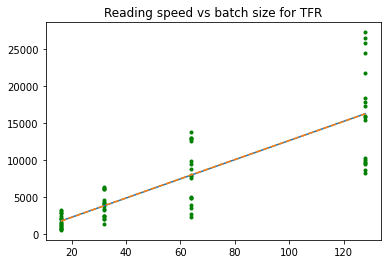

325.61027882226375 937.0735664086196 0.39308321650083733 0.0006363068136301243 91.0369478264956


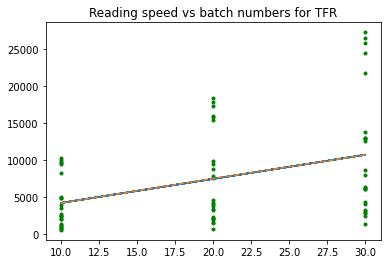

6.079612305383909 153.7443763932033 0.9421951925591471 5.780011746413311e-35 0.25841302393513776


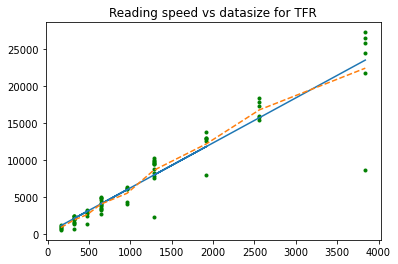

116.85415566336836 7176.619446306036 0.012877748336871152 0.9145007428144459 1084.4741243808185


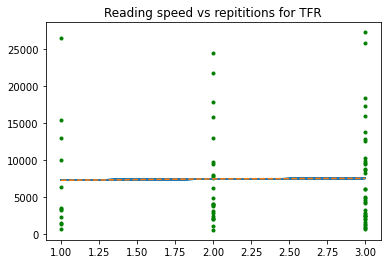

127.51163431430126 -23.93791226897156 0.8239022127139173 6.245901361550375e-19 10.483416671085278


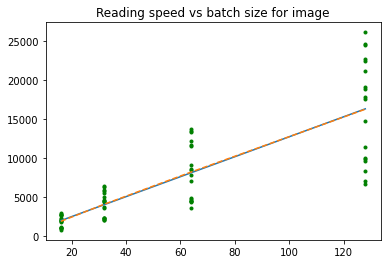

353.2597499798881 561.5651469913419 0.4344756816833717 0.00013708559254236514 87.52898683754228


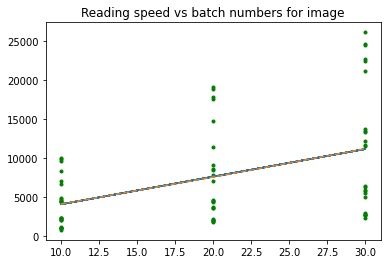

6.220485291582378 162.17779669025003 0.9821417824531713 1.5830464990681721e-52 0.1424254082504389


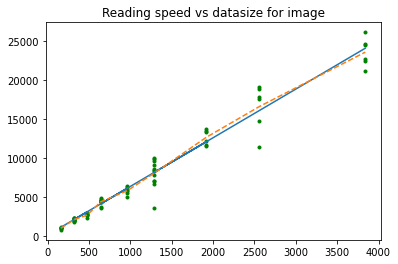

134.72617155339356 7312.3990796311855 0.015126298340593038 0.8996434654342409 1064.438555447202


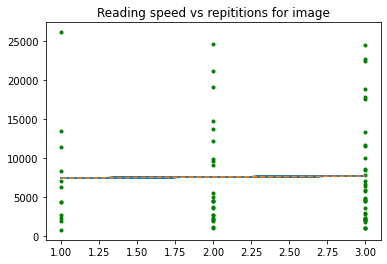

In [ ]:
### CODING for TASK 2d ### 


import scipy as sp
import numpy as np
from matplotlib import pyplot as plt


def plot_linear_reg(out_val, avg_par, title):
    x = [x[0] for x in out_val] # creating independent variables or features
    y = [y[1] for y in out_val] # creating dependent variables or targets
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(np.array(x), np.array(y))
    print(slope, intercept, r_value, p_value, std_err)
    regression_line = intercept + slope * np.array(x) # creating a regression line based on equation of a straight line.
    sorted_avg_par = sorted(avg_par, key=lambda x: x[0]) # for an odered values to be plotted
    sorted_avg_par_x = [x[0] for x in sorted_avg_par]
    sorted_avg_par_y = [y[1] for y in sorted_avg_par]
    plt.plot(x, y, 'g.')
    plt.plot(x, regression_line)
    plt.plot(sorted_avg_par_x, sorted_avg_par_y, '--')
    plt.title(title)
    plt.show()


plot_linear_reg(param_combis[0], param_combis[8], 'Reading speed vs batch size for TFR')

plot_linear_reg(param_combis[1], param_combis[9], 'Reading speed vs batch numbers for TFR')

plot_linear_reg(param_combis[2], param_combis[10], 'Reading speed vs datasize for TFR')

plot_linear_reg(param_combis[3], param_combis[11], 'Reading speed vs repititions for TFR')

plot_linear_reg(param_combis[4], param_combis[12], 'Reading speed vs batch size for image')

plot_linear_reg(param_combis[5], param_combis[13], 'Reading speed vs batch numbers for image')

plot_linear_reg(param_combis[6], param_combis[14], 'Reading speed vs datasize for image')

plot_linear_reg(param_combis[7], param_combis[15], 'Reading speed vs repititions for image')


# Section 3: Machine Learning in the Cloud

In this section we will use the pre-processed data with the Google Cloud AI-Platform for Machine Learning. 

Heavily based on Lab sheet 8: Deep Learning handwwritten digits classification with CNNs.

## Preparation: Machine Learning Setup

As in Section 1, in this section, we get started based on code from the 'Fast and Lean Data Science' course, this time lecture 4, to establish the task.

Switch to a runtime with a GPU before you run this section. You'll need to re-run section 0 and 1 up to (but not including) Task 1 after you switch runtimes to set everything up. 


### Create Train and Test Sets 

We will first **set up a few variables** for the machine learning. 

In [ ]:
BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

Then we split the data into train and test sets.

In [ ]:
# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
print("len(filenames): "+str(len(filenames)))
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

len(filenames): 16
Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


Then we split the train and validation sets into batches. 

In [ ]:
def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

In [ ]:
# just a little test to check the datasets
sample_set = training_dataset.take(4)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape,
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (64, 192, 192, 3), ['0', '0', '4', '1', '0', '2', '0', '1', '3', '4', '2', '1', '3', '1', '0', '2', '4', '3', '4', '1', '4', '0', '0', '4', '4', '1', '4', '4', '0', '3', '2', '3', '3', '3', '3', '1', '0', '1', '3', '4', '3', '1', '1', '4', '2', '4', '1', '3', '2', '3', '3', '0', '3', '3', '3', '2', '0', '4', '4', '1', '4', '1', '3', '1'])
Image batch shape (64, 192, 192, 3), ['4', '4', '2', '0', '2', '2', '4', '1', '3', '3', '3', '1', '4', '2', '3', '4', '1', '3', '2', '1', '0', '2', '3', '0', '2', '4', '1', '2', '4', '3', '2', '3', '3', '4', '3', '3', '1', '2', '1', '4', '4', '4', '0', '2', '3', '4', '2', '1', '1', '4', '0', '3', '0', '4', '4', '4', '1', '1', '4', '4', '1', '3', '3', '0'])
Image batch shape (64, 192, 192, 3), ['3', '0', '1', '3', '1', '4', '2', '0', '0', '0', '2', '4', '4', '4', '2', '3', '2', '3', '0', '4', '2', '4', '1', '2', '1', '0', '4', '0', '1', '1', '4', '0', '4', '2', '3', '4', '3', '3', '1', '4', '2', '3', '1', '1', '4', '2', '2', '1', '1',

### Set up a pretrained model

Here we load a **pre-trained model** and add a **fully connected** layer plus the **output layer**.
**Only** our **added layers** are **trained**, which lets us benefit from the trained model without the computation or data needed to re-train from scratch.

We use **MobileNetV2** here, which is a **relatively small and efficient** model. You can also try the larger ones, if you like. 

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 46080)             0         
                                                                 
 dense (Dense)               (None, 100)               4608100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 6,866,589
Trainable params: 4,608,605
Non-tra

### Local Training

With **model and data**, we can now start the **training**. You can keep training time short by making sure that you use a runtime with GPU. You should also the number of epochs low, for initial tests. 
The **history** object keeps a record of the training progress.

In [ ]:
tt0 = time.time()
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                    validation_data=validation_dataset, validation_steps=validation_steps)
tt = time.time() - tt0
print("Wall clock time = {}".format(tt))

Epoch 1/5
46/46 [==============================] - 83s 2s/step - loss: 3.5233 - accuracy: 0.2480 - val_loss: 1.6009 - val_accuracy: 0.2406
Epoch 2/5
46/46 [==============================] - 81s 2s/step - loss: 1.5951 - accuracy: 0.2463 - val_loss: 1.5677 - val_accuracy: 0.2406
Epoch 3/5
46/46 [==============================] - 81s 2s/step - loss: 1.5829 - accuracy: 0.2473 - val_loss: 1.6027 - val_accuracy: 0.2422
Epoch 4/5
46/46 [==============================] - 80s 2s/step - loss: 1.5943 - accuracy: 0.2469 - val_loss: 1.5594 - val_accuracy: 0.2422
Epoch 5/5
46/46 [==============================] - 80s 2s/step - loss: 1.5874 - accuracy: 0.2452 - val_loss: 1.5513 - val_accuracy: 0.2422
Wall clock time = 444.85042095184326


As a result we have the printed training time, the trained model, and the history object, which we can visualise (not essential for us here).

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


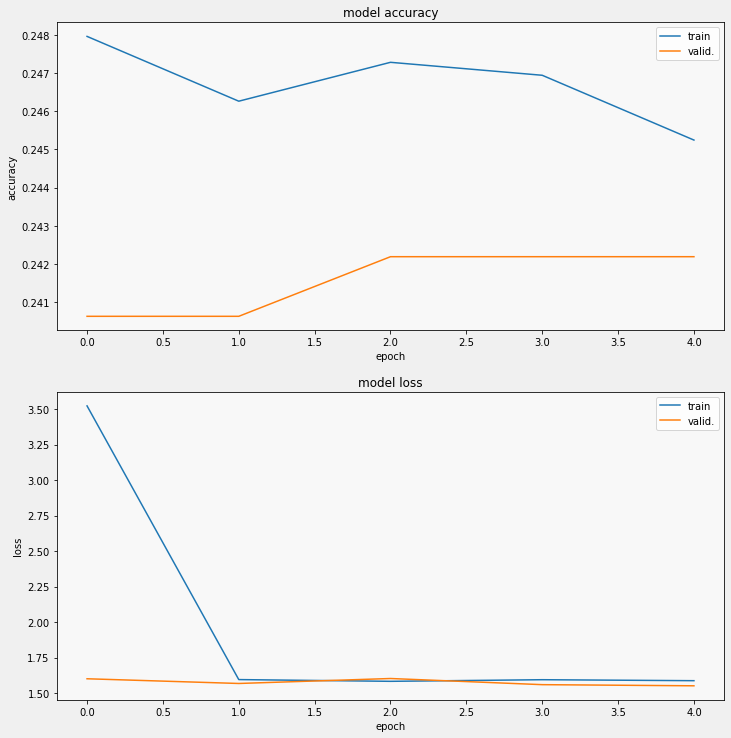

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

We can check a few examples with the predicted classes.

In [ ]:
# random input: execute multiple times to change results
flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

[b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion']


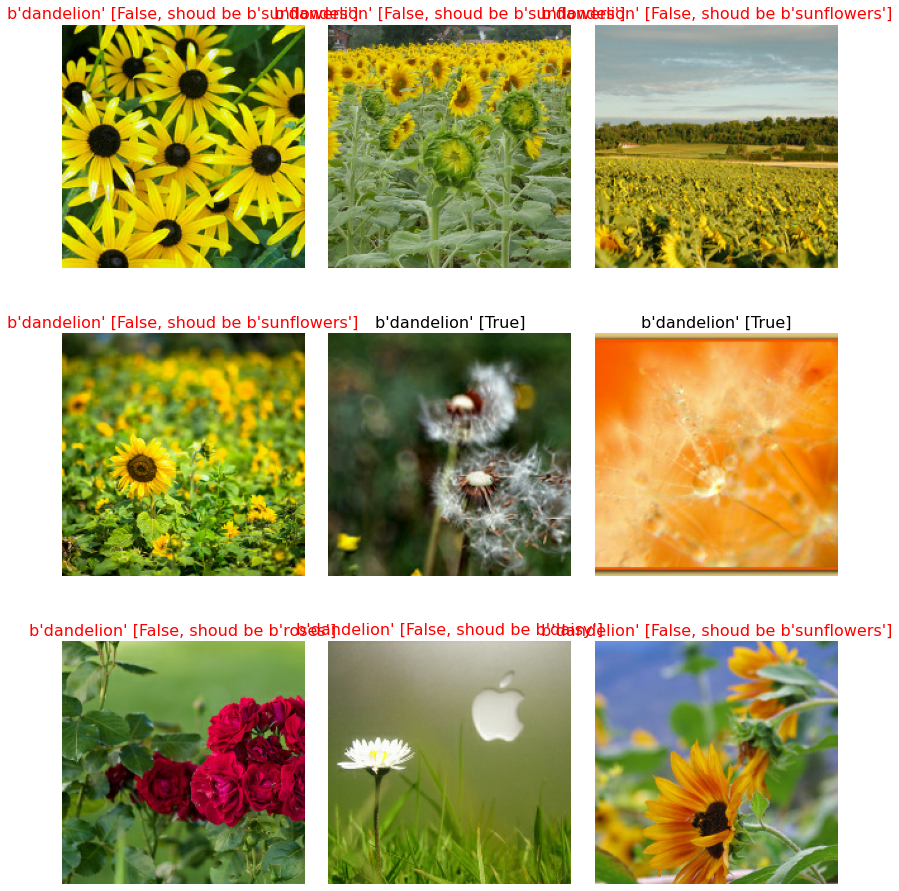

In [ ]:
display_9_images_with_predictions(flowers, predictions, labels)

## Task 3: Machine learning in the cloud (20%)

Your task is now to **execute** the **training** in the **cloud** on the **AI-Platform** and experiment with different parallelisation approaches.


### 3a) Create the package and code for the AI-Platform (7%)

The AI Platform needs code in a '**package**'. 
The package can contain complex software systems and extensive  information on the setup. 
We will **keep** the package as **simple** as possible here.



i) The **minimal** 'package' in for AI-Platform needs a directory with **two modules** (i.e. Python files). 
Create a directory 'trainer' and then an empty file **`trainer/__init__.py`**. 
This can be done by using the **command line tool `touch`**. 
**Check** that the file **exists**. (1%) 

In [ ]:
### CODING for TASK 3a ###
!mkdir trainer
!touch trainer/__init__.py
!ls -lh trainer 

# Reference: Lab 9b

total 0
-rw-r--r-- 1 root root 0 May  4 01:34 __init__.py


ii) The other file we need is the **module** with the **training code**, which we will call **`task.py`**. 

We can build this file by **combining** the **previous cells** under 'Machine Learning Setup' into one file, almost literally. 

Then, we need to **save the model itself** and the **training history** into a file after training. 
You can not pickle the `history` object returned by `model.fit`, but its **data in `history.history`** can be **pickled**. 
For **saving the model**, use `model.save()`.
In addition, **save** the measured **training time** and information about the **configuration** (should be passed as a parameter). 
Write the necessary code, like in section 2 when preparing jobs for Spark/Dataproc.

If you use **argparse** as in section 2 (recommended), then you need to **define an argument** `--job-dir` that will be passed through from the AI-Platform to your program when you define it.
(6%)

In [ ]:
### Building code and testing locally for errors. ###


import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse




def save(object, bucket, filename):
   with open(filename,mode='wb') as f:
       pickle.dump(object,f)
   print("Saving {} to {}".format(filename,bucket))
   import subprocess
   proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
   print("gstuil returned: " + str(proc.returncode))
   print(str(proc.stderr))

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def model_train(argv):
    # argv = sys.argv[1:]
    parser = argparse.ArgumentParser()
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True, help='The directory for the job.')
    parser.add_argument('--out_file', metavar='out_file', required=True, help='The filename for the result.')
    args = parser.parse_args(argv)
    # model.save(args.job_dir)    # -- Save model       ### job dir is to be assigned a path so that it can be used as an argument for save function.
    # save(tt, args.job_dir, '64training-time.pkl')   # -- Save training time
    # save(history.history, args.job_dir, '64history.pkl')    # --  Save training history
    # BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)
    # #BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform)
    # EPOCHS = 5 # 5 is for testing. Increase later
    # GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
    # # this is a link to public data, you can use your own if you like
    # VALIDATION_SPLIT = 0.19 # proportion of data used for validation
    # SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets
    # # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))
    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
    pretrained_model.trainable = False
    model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(5, activation='softmax')
    ])
    model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
    model.summary()
    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                    validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0
    print("Wall clock time = {}".format(tt))
    model.save(args.out_bucket)    # -- Save model       ### job dir is to be assigned a path so that it can be used as an argument for save function.
    save(tt, args.out_bucket, args.out_file)   # -- Save training time
    save(history.history, args.out_bucket, args.out_file)    # --  Save training history


# def read_tfrecord(example):
#     features = {
#         "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
#         "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
#     }
#     # decode the TFRecord
#     example = tf.io.parse_single_example(example, features)
#     image = tf.image.decode_jpeg(example['image'], channels=3)
#     image = tf.reshape(image, [*TARGET_SIZE, 3])    
#     class_num = example['class']
#     return image, class_num 

# def load_dataset(filenames):
#     # read from TFRecords. For optimal performance, read from multiple    
#     # TFRecord files at once and set the option experimental_deterministic = False
#     # to allow order-altering optimizations.
#     option_no_order = tf.data.Options()
#     option_no_order.experimental_deterministic = False

#     dataset = tf.data.TFRecordDataset(filenames)
#     dataset = dataset.with_options(option_no_order)
#     dataset = dataset.map(read_tfrecord)
#     return dataset

# def get_batched_dataset(filenames, train=False):
#     dataset = load_dataset(filenames)
#     dataset = dataset.cache() # This dataset fits in RAM
#     if train:
#         # Best practices for Keras:
#         # Training dataset: repeat then batch
#         # Evaluation dataset: do not repeat
#         dataset = dataset.repeat()
#     dataset = dataset.batch(BATCH_SIZE)
#     dataset = dataset.prefetch(1) # prefetch next batch while training 
#     # should shuffle too but this dataset was well shuffled on disk already
#     return dataset
#     # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
# training_dataset = get_batched_dataset(training_filenames, train=True)
# validation_dataset = get_batched_dataset(validation_filenames, train=False)

# pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
# pretrained_model.trainable = False

# model = tf.keras.Sequential([
#     pretrained_model,
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(100,activation='relu'),
#     tf.keras.layers.Dropout(.5),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])

# model.compile(
#     optimizer='adam',
#     loss = 'sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# model.summary()

# tt0 = time.time()
# history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
#                     validation_data=validation_dataset, validation_steps=validation_steps)
# tt = time.time() - tt0
# print("Wall clock time = {}".format(tt))



# argv = sys.argv[1:]
# parser = argparse.ArgumentParser()
# parser.add_argument('--job-dir', metavar='job_dir', required=True, help='The directory for the job.')
# args = parser.parse_args(argv)
# model.save(args.job_dir)    # -- Save model       ### job dir is to be assigned a path so that it can be used as an argument for save function.
# save(tt, args.job_dir, '64training-time.pkl')   # -- Save training time
# save(history.history, args.job_dir, '64history.pkl')    # --  Save training history
if __name__ == "__main__" : # but define them manually
    model_train(["--out_bucket", BUCKET, "--out_file", "task_3a_2.pkl"])


Tensorflow version 2.8.0
len(filenames): 16
Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 46080)             0         
                                                                 
 dense_2 (Dense)             (None, 100)               4608100   
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_

INFO:tensorflow:Assets written to: gs://astral-sunbeam-344511-storage/assets


INFO:tensorflow:Assets written to: gs://astral-sunbeam-344511-storage/assets


Saving task_3a_2.pkl to gs://astral-sunbeam-344511-storage
gstuil returned: 0
b'Copying file://task_3a_2.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/   12.0 B]                                                \r/ [1 files][   12.0 B/   12.0 B]                                                \r\nOperation completed over 1 objects/12.0 B.                                       \n'
Saving task_3a_2.pkl to gs://astral-sunbeam-344511-storage
gstuil returned: 0
b'Copying file://task_3a_2.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/  268.0 B]                                                \r/ [1 files][  268.0 B/  268.0 B]                                                \r\nOperation completed over 1 objects/268.0 B.                                      \n'


In [ ]:
# Another trial of code without argparse

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse




def save(object, bucket, filename):
   with open(filename,mode='wb') as f:
       pickle.dump(object,f)
   print("Saving {} to {}".format(filename,bucket))
   import subprocess
   proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
   print("gstuil returned: " + str(proc.returncode))
   print(str(proc.stderr))

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def model_train_1(out_bucket, out_file):
    # argv = sys.argv[1:]
    # parser = argparse.ArgumentParser()
    # parser.add_argument('--out_bucket', metavar='out_bucket', required=True, help='The directory for the job.')
    # parser.add_argument('--out_file', metavar='out_file', required=True, help='The filename for the result.')
    # args = parser.parse_args(argv)
    # # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))
    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
    pretrained_model.trainable = False
    model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(5, activation='softmax')
    ])
    model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
    model.summary()
    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                    validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0
    print("Wall clock time = {}".format(tt))
    model.save(out_bucket)    # -- Save model       ### job dir is to be assigned a path so that it can be used as an argument for save function.
    save(tt, out_bucket, out_file)   # -- Save training time
    save(history.history, out_bucket, out_file)    # --  Save training history


if __name__ == "__main__" : # but define them manually
    model_train_1(BUCKET, "task_3a_2_1.pkl")


Tensorflow version 2.8.0
len(filenames): 16
Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 46080)             0         
                                                                 
 dense_4 (Dense)             (None, 100)               4608100   
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_

INFO:tensorflow:Assets written to: gs://astral-sunbeam-344511-storage/assets


INFO:tensorflow:Assets written to: gs://astral-sunbeam-344511-storage/assets


Saving task_3a_2_1.pkl to gs://astral-sunbeam-344511-storage
gstuil returned: 0
b'Copying file://task_3a_2_1.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/   12.0 B]                                                \r/ [1 files][   12.0 B/   12.0 B]                                                \r\nOperation completed over 1 objects/12.0 B.                                       \n'
Saving task_3a_2_1.pkl to gs://astral-sunbeam-344511-storage
gstuil returned: 0
b'Copying file://task_3a_2_1.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/  268.0 B]                                                \r/ [1 files][  268.0 B/  268.0 B]                                                \r\nOperation completed over 1 objects/268.0 B.                                      \n'


In [ ]:
# Although the output is similar, argparse gives the flexibility of using function with just one input or argument.
# So, its better to use argparse.

In [ ]:
### CODING for TASK 3b ###
%%writefile trainer/task.py

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse



PROJECT = 'astral-sunbeam-344511'  ### USE YOUR PROJECT ID HERE. ### 
CLUSTER = '{}-cluster'.format(PROJECT)
BUCKET = 'gs://{}-storage'.format(PROJECT)

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images


BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets



def save(object, bucket, filename):
   with open(filename,mode='wb') as f:
       pickle.dump(object,f)
   print("Saving {} to {}".format(filename,bucket))
   import subprocess
   proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
   print("gstuil returned: " + str(proc.returncode))
   print(str(proc.stderr))

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def model_train(argv):
    # argv = sys.argv[1:]
    parser = argparse.ArgumentParser()
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True, help='The directory for the job.')
    parser.add_argument('--out_file', metavar='out_file', required=True, help='The filename for the result.')
    args = parser.parse_args(argv)
    # # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))
    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
    pretrained_model.trainable = False
    model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(5, activation='softmax')
    ])
    model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
    model.summary()
    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                    validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0
    print("Wall clock time = {}".format(tt))
    model.save(args.out_bucket)    # -- Save model       ### job dir is to be assigned a path so that it can be used as an argument for save function.
    save(tt, args.out_bucket, args.out_file)   # -- Save training time
    save(history.history, args.out_bucket, args.out_file)    # --  Save training history



filename_1 = "task_3a_2.pkl"

if __name__ == "__main__" : # but define them manually
    model_train(["--out_bucket", BUCKET, "--out_file", filename_1])


Overwriting trainer/task.py


### 3b) Run the Training on the AI-Platform and view the Output (3%)

Now, with all code in place, we can **submit the package as a job**. AI-Platform operation is **serverless**, therefore we do not need to create a cluster ourselves, but we just submit a job and the master and workers will be provided automatically. 
Find [here](https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training) the information **how to submit a training job** in GCS AI-Platform.  

The **job** will wait in a **queue** for **some minutes** before it gets executed, this can take several minutes (at least on free credits). 
It's therefore a good idea to **test** the script **locally before** you submit to the **cloud**. 

You can get **powerful hardware** on AI-Platform. Up to 30 K80 or even P100 GPUs are available, but not all configurations are possible. 
Check [here](https://cloud.google.com/ai-platform/training/docs/quotas#gpu-quota) and [here](https://cloud.google.com/ai-platform/training/docs/using-gpus), and test [here on the console](https://console.cloud.google.com/ai-platform/create-job/custom-code?folder=true&organizationId=true) with the Create option whether your configuration works in the Google Cloud.

However, the machines with P100 and V100 GPUs are quite **expensive**. 
For the experiments here, the `standard_gpu` (1xK80) and the `complex_model_l_gpu` (8xK80) are sufficient.


**Submitting job on Cloud local**

In [ ]:
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="flowers_training" # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform local train \
    --job-dir $JOB_DIR  \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    -- --config standard_gpu --batch-size 32

### CODING TASK ### 

Tensorflow version 2.8.0
len(filenames): 16
Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.
2022-04-29 15:23:56.642741: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 46080)             0         
                                                                 
 dense (Dense)               (None, 100)               4608100   
                                             

**standard_gpu (1xK80)**

In [ ]:
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="flowers_training"+NOW # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --staging-bucket $PACKAGE_STAGING_PATH \
    --job-dir $JOB_DIR  \
    --region $REGION  \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --scale-tier custom \
    --master-machine-type standard_gpu

### CODING TASK ### 

Job [flowers_training220429_1542] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe flowers_training220429_1542

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs flowers_training220429_1542
jobId: flowers_training220429_1542
state: QUEUED


**complex_model_l_gpu (8xK80)**

In [ ]:
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="flowers_training"+NOW # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --staging-bucket $PACKAGE_STAGING_PATH \
    --job-dir $JOB_DIR  \
    --region $REGION  \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --scale-tier custom \
    --master-machine-type complex_model_l_gpu

### CODING TASK ### 

Job [flowers_training220429_1606] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe flowers_training220429_1606

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs flowers_training220429_1606
jobId: flowers_training220429_1606
state: QUEUED


Normally, gcloud returns immediately after job submission. If you want to keep track here, you can use the cell below. Usually, it is more practical to use the web interface https://console.cloud.google.com/ai-platform/jobs .

In [ ]:
!gcloud ai-platform jobs stream-logs $JOB_NAME

After training, **retrieve the history object and plot** the accuracy and loss curves based on the saved history to **check that the training worked**.

In [ ]:
# load saved history of model run on gcloud ai-platform

### CODING TASK ### 
!gsutil cp $BUCKET/task_3a_2.pkl . 
with open("task_3a_2.pkl",mode='rb') as f:
    model3b_history = pickle.load(f)

Copying gs://astral-sunbeam-344511-storage/task_3a_2.pkl...
/ [1 files][  268.0 B/  268.0 B]                                                
Operation completed over 1 objects/268.0 B.                                      


In [ ]:
type(model3b_history) # check its data type to view it

dict

In [ ]:
model3b_history.keys() # check the keys to understant the structure of dictionary

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

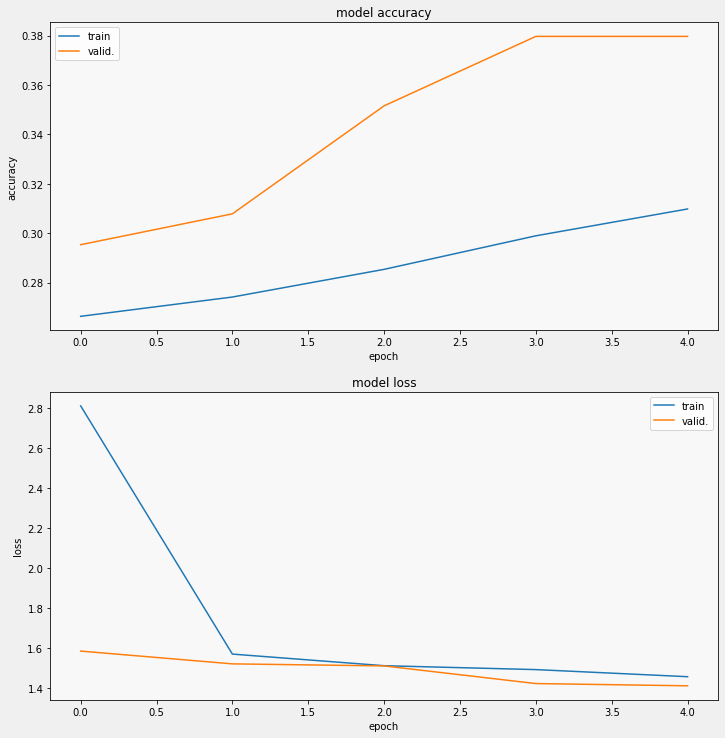

In [ ]:
display_training_curves(model3b_history['accuracy'], model3b_history['val_accuracy'], 'accuracy', 211)
display_training_curves(model3b_history['loss'], model3b_history['val_loss'], 'loss', 212)

### 3c) Distributed learning	(10%)

Apply **distributed learning strategies** to the code (see https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras?hl=nb#choose_the_right_strategy for an example).  
Add the necessary changes to the code.

**Experiment** with **different strategies and batch sizes**. Report and interpret your results. 
For the defining cluster sizes, you can use command line options as described here: https://cloud.google.com/ai-platform/training/docs/machine-types#legacy-machine-types . 
Check the pricing here ( https://cloud.google.com/ai-platform/training/pricing ) and make sure everything works before you run jobs on the expensive configurations. 


***OneDevice Strategy with batch size 16 run locally.***

In [ ]:
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task3c_mwm128"
PACKAGE_STAGING_PATH=BUCKET
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
JOB_NAME="flowers_training"+NOW # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --staging-bucket $PACKAGE_STAGING_PATH \
    --job-dir $JOB_DIR  \
    --region $REGION  \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --scale-tier custom \
    --master-machine-type complex_model_l_gpu### CODING TASK ###

### CODING TASK ###
# %%writefile trainer/task.py

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse
import json
import os
import sys


os.environ.pop('TF_CONFIG', None)

PROJECT = 'astral-sunbeam-344511'  ### USE YOUR PROJECT ID HERE. ### 
CLUSTER = '{}-cluster'.format(PROJECT)
BUCKET = 'gs://{}-storage'.format(PROJECT)

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images


BATCH_SIZE = 16 # this is a good setting for the standard Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

tf_config = {
    'cluster': {
        'worker': ['localhost:12345', 'localhost:23456']
    },
    'task': {'type': 'worker', 'index': 0}
}

json.dumps(tf_config)

strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

def save(object, bucket, filename):
   with open(filename,mode='wb') as f:
       pickle.dump(object,f)
   print("Saving {} to {}".format(filename,bucket))
   import subprocess
   proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
   print("gstuil returned: " + str(proc.returncode))
   print(str(proc.stderr))

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def model_train(argv):
    # argv = sys.argv[1:]
    parser = argparse.ArgumentParser()
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True, help='The directory for the job.')
    parser.add_argument('--out_file', metavar='out_file', required=True, help='The filename for the result.')
    args = parser.parse_args(argv)
    # # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))
    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)
    
    with strategy.scope():
      pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
      pretrained_model.trainable = False
      model = tf.keras.Sequential([
      pretrained_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100,activation='relu'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(5, activation='softmax')
      ])
      model.compile(
      optimizer='adam',
      loss = 'sparse_categorical_crossentropy',
      metrics=['accuracy']
      )
      model.summary()
    
    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                    validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0
    print("Wall clock time = {}".format(tt))
    model.save(args.out_bucket)    # -- Save model       ### job dir is to be assigned a path so that it can be used as an argument for save function.
    save(tt, args.out_bucket, args.out_file)   # -- Save training time
    save(history.history, args.out_bucket, args.out_file)    # --  Save training history



filename_1 = "task_3c_od.pkl"

if __name__ == "__main__" : # but define them manually
    model_train(["--out_bucket", BUCKET, "--out_file", filename_1])

Tensorflow version 2.8.0
len(filenames): 16
Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 16, there will be 186 batches per training epoch and 42 batch(es) per validation run.
9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 46080)             0         
                                                                 
 dense (Dense)               (None, 100)               4608100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
           

INFO:tensorflow:Assets written to: gs://astral-sunbeam-344511-storage/assets


INFO:tensorflow:Assets written to: gs://astral-sunbeam-344511-storage/assets


Saving task_3c_od.pkl to gs://astral-sunbeam-344511-storage
gstuil returned: 0
b'Copying file://task_3c_od.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/   12.0 B]                                                \r/ [1 files][   12.0 B/   12.0 B]                                                \r-\r\nOperation completed over 1 objects/12.0 B.                                       \n'
Saving task_3c_od.pkl to gs://astral-sunbeam-344511-storage
gstuil returned: 0
b'Copying file://task_3c_od.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/  268.0 B]                                                \r/ [1 files][  268.0 B/  268.0 B]                                                \r-\r\nOperation completed over 1 objects/268.0 B.                                      \n'


***OneDevice Strategy with batch size 16 run on Standard GPU.***





In [ ]:
%%writefile trainer/task3c_od16.py

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse
import json
import os
import sys


os.environ.pop('TF_CONFIG', None)

PROJECT = 'astral-sunbeam-344511'  ### USE YOUR PROJECT ID HERE. ### 
CLUSTER = '{}-cluster'.format(PROJECT)
BUCKET = 'gs://{}-storage'.format(PROJECT)

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images


BATCH_SIZE = 16 # this is a good setting for the standard Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

tf_config = {
    'cluster': {
        'worker': ['localhost:12345', 'localhost:23456']
    },
    'task': {'type': 'worker', 'index': 0}
}

json.dumps(tf_config)

strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

def save(object, bucket, filename):
   with open(filename,mode='wb') as f:
       pickle.dump(object,f)
   print("Saving {} to {}".format(filename,bucket))
   import subprocess
   proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
   print("gstuil returned: " + str(proc.returncode))
   print(str(proc.stderr))

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def model_train(argv):
    # argv = sys.argv[1:]
    parser = argparse.ArgumentParser()
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True, help='The directory for the job.')
    parser.add_argument('--out_file', metavar='out_file', required=True, help='The filename for the result.')
    args = parser.parse_args(argv)
    # # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))
    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)
    
    with strategy.scope():
      pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
      pretrained_model.trainable = False
      model = tf.keras.Sequential([
      pretrained_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100,activation='relu'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(5, activation='softmax')
      ])
      model.compile(
      optimizer='adam',
      loss = 'sparse_categorical_crossentropy',
      metrics=['accuracy']
      )
      model.summary()
    
    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                    validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0
    print("Wall clock time = {}".format(tt))
    model.save(args.out_bucket)    # -- Save model       ### job dir is to be assigned a path so that it can be used as an argument for save function.
    save(tt, args.out_bucket, args.out_file)   # -- Save training time
    save(history.history, args.out_bucket, args.out_file)    # --  Save training history



filename_1 = "task_3c_od16.pkl"

if __name__ == "__main__" : # but define them manually
    model_train(["--out_bucket", BUCKET, "--out_file", filename_1])

Overwriting trainer/task3c_od16.py


In [ ]:
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task3c_od16"
PACKAGE_STAGING_PATH=BUCKET
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
JOB_NAME="flowers_training"+NOW # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --staging-bucket $PACKAGE_STAGING_PATH \
    --job-dir $JOB_DIR  \
    --region $REGION  \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --scale-tier custom \
    --master-machine-type standard_gpu

Job [flowers_training220503_0353] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe flowers_training220503_0353

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs flowers_training220503_0353
jobId: flowers_training220503_0353
state: QUEUED


***MultiWorkerMirrored Strategy with batch size 64 run on Model L GPU.***

In [ ]:
### CODING TASK ###


%%writefile trainer/task3c_mwm128.py

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse
import json
import os
import sys


# os.environ.pop('TF_CONFIG', None)

TF_CONFIG = os.environ.get('TF_CONFIG')
if TF_CONFIG and '"master"' in TF_CONFIG:
  os.environ['TF_CONFIG'] = TF_CONFIG.replace('"master"', '"chief"')




PROJECT = 'astral-sunbeam-344511'  ### USE YOUR PROJECT ID HERE. ### 
CLUSTER = '{}-cluster'.format(PROJECT)
BUCKET = 'gs://{}-storage'.format(PROJECT)

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images


# BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)
BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

# tf_config = {
#     'cluster': {
#         'worker': ['localhost:12345', 'localhost:23456']
#     },
#     'task': {'type': 'worker', 'index': 0}
# }

# json.dumps(tf_config)

strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

def save(object, bucket, filename):
   with open(filename,mode='wb') as f:
       pickle.dump(object,f)
   print("Saving {} to {}".format(filename,bucket))
   import subprocess
   proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
   print("gstuil returned: " + str(proc.returncode))
   print(str(proc.stderr))

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def model_train(argv):
    # argv = sys.argv[1:]
    parser = argparse.ArgumentParser()
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True, help='The directory for the job.')
    parser.add_argument('--out_file', metavar='out_file', required=True, help='The filename for the result.')
    args = parser.parse_args(argv)
    # # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))
    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)
    
    with strategy.scope():
      pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
      pretrained_model.trainable = False
      model = tf.keras.Sequential([
      pretrained_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100,activation='relu'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(5, activation='softmax')
      ])
      model.compile(
      optimizer='adam',
      loss = 'sparse_categorical_crossentropy',
      metrics=['accuracy']
      )
      model.summary()
    
    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                    validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0
    print("Wall clock time = {}".format(tt))
    model.save(args.out_bucket)    # -- Save model       ### job dir is to be assigned a path so that it can be used as an argument for save function.
    save(tt, args.out_bucket, args.out_file)   # -- Save training time
    save(history.history, args.out_bucket, args.out_file)    # --  Save training history



filename_1 = "task_3c_mwm128.pkl"

if __name__ == "__main__" : # but define them manually
    model_train(["--out_bucket", BUCKET, "--out_file", filename_1])

Writing trainer/task3c_mwm128.py


In [ ]:
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task3c_mwm128"
PACKAGE_STAGING_PATH=BUCKET
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
JOB_NAME="flowers_training"+NOW # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --staging-bucket $PACKAGE_STAGING_PATH \
    --job-dir $JOB_DIR  \
    --region $REGION  \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --scale-tier custom \
    --master-machine-type complex_model_l_gpu

Job [flowers_training220503_0404] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe flowers_training220503_0404

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs flowers_training220503_0404
jobId: flowers_training220503_0404
state: QUEUED


In [ ]:
## NOTE: MultiWorkerMirrored Strategy failed to work on gcloud ai-platform.

***Mirrored Strategy with batch size 128 run on Model L GPU.***

In [ ]:
### CODING TASK ###


%%writefile trainer/task3c_m128.py

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse
import json
import os
import sys


os.environ.pop('TF_CONFIG', None)

PROJECT = 'astral-sunbeam-344511'  ### USE YOUR PROJECT ID HERE. ### 
CLUSTER = '{}-cluster'.format(PROJECT)
BUCKET = 'gs://{}-storage'.format(PROJECT)

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images


# BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)
BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

tf_config = {
    'cluster': {
        'worker': ['localhost:12345', 'localhost:23456']
    },
    'task': {'type': 'worker', 'index': 0}
}

json.dumps(tf_config)

strategy = tf.distribute.MirroredStrategy()

def save(object, bucket, filename):
   with open(filename,mode='wb') as f:
       pickle.dump(object,f)
   print("Saving {} to {}".format(filename,bucket))
   import subprocess
   proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
   print("gstuil returned: " + str(proc.returncode))
   print(str(proc.stderr))

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def model_train(argv):
    # argv = sys.argv[1:]
    parser = argparse.ArgumentParser()
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True, help='The directory for the job.')
    parser.add_argument('--out_file', metavar='out_file', required=True, help='The filename for the result.')
    args = parser.parse_args(argv)
    # # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))
    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)
    
    with strategy.scope():
      pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
      pretrained_model.trainable = False
      model = tf.keras.Sequential([
      pretrained_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100,activation='relu'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(5, activation='softmax')
      ])
      model.compile(
      optimizer='adam',
      loss = 'sparse_categorical_crossentropy',
      metrics=['accuracy']
      )
      model.summary()
    
    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                    validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0
    print("Wall clock time = {}".format(tt))
    model.save(args.out_bucket)    # -- Save model       ### job dir is to be assigned a path so that it can be used as an argument for save function.
    save(tt, args.out_bucket, args.out_file)   # -- Save training time
    save(history.history, args.out_bucket, args.out_file)    # --  Save training history



filename_1 = "task_3c_m128.pkl"

if __name__ == "__main__" : # but define them manually
    model_train(["--out_bucket", BUCKET, "--out_file", filename_1])

Writing trainer/task3c_m128.py


In [ ]:
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task3c_m128"
PACKAGE_STAGING_PATH=BUCKET
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
JOB_NAME="flowers_training"+NOW # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --staging-bucket $PACKAGE_STAGING_PATH \
    --job-dir $JOB_DIR  \
    --region $REGION  \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --scale-tier custom \
    --master-machine-type complex_model_l_gpu

Job [flowers_training220503_0419] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe flowers_training220503_0419

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs flowers_training220503_0419
jobId: flowers_training220503_0419
state: QUEUED


***CentralStorage Strategy with batch size 128 run on Model L GPU.***

In [ ]:
### CODING TASK ###


%%writefile trainer/task3c_cs128.py

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse
import json
import os
import sys


os.environ.pop('TF_CONFIG', None)

PROJECT = 'astral-sunbeam-344511'  ### USE YOUR PROJECT ID HERE. ### 
CLUSTER = '{}-cluster'.format(PROJECT)
BUCKET = 'gs://{}-storage'.format(PROJECT)

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images


# BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)
BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

tf_config = {
    'cluster': {
        'worker': ['localhost:12345', 'localhost:23456']
    },
    'task': {'type': 'worker', 'index': 0}
}

json.dumps(tf_config)

strategy = tf.distribute.experimental.CentralStorageStrategy()

def save(object, bucket, filename):
   with open(filename,mode='wb') as f:
       pickle.dump(object,f)
   print("Saving {} to {}".format(filename,bucket))
   import subprocess
   proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
   print("gstuil returned: " + str(proc.returncode))
   print(str(proc.stderr))

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def model_train(argv):
    # argv = sys.argv[1:]
    parser = argparse.ArgumentParser()
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True, help='The directory for the job.')
    parser.add_argument('--out_file', metavar='out_file', required=True, help='The filename for the result.')
    args = parser.parse_args(argv)
    # # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))
    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)
    
    with strategy.scope():
      pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
      pretrained_model.trainable = False
      model = tf.keras.Sequential([
      pretrained_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100,activation='relu'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(5, activation='softmax')
      ])
      model.compile(
      optimizer='adam',
      loss = 'sparse_categorical_crossentropy',
      metrics=['accuracy']
      )
      model.summary()
    
    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                    validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0
    print("Wall clock time = {}".format(tt))
    model.save(args.out_bucket)    # -- Save model       ### job dir is to be assigned a path so that it can be used as an argument for save function.
    save(tt, args.out_bucket, args.out_file)   # -- Save training time
    save(history.history, args.out_bucket, args.out_file)    # --  Save training history



filename_1 = "task_3c_cs128.pkl"

if __name__ == "__main__" : # but define them manually
    model_train(["--out_bucket", BUCKET, "--out_file", filename_1])

Writing trainer/task3c_cs128.py


In [ ]:
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task3c_cs128"
PACKAGE_STAGING_PATH=BUCKET
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
JOB_NAME="flowers_training"+NOW # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --staging-bucket $PACKAGE_STAGING_PATH \
    --job-dir $JOB_DIR  \
    --region $REGION  \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --scale-tier custom \
    --master-machine-type complex_model_l_gpu

Job [flowers_training220503_0519] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe flowers_training220503_0519

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs flowers_training220503_0519
jobId: flowers_training220503_0519
state: QUEUED


***OneDevice Strategy with batch size 128 run on Model L GPU.***

In [ ]:
%%writefile trainer/task3c_od128.py

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse
import json
import os
import sys


os.environ.pop('TF_CONFIG', None)

PROJECT = 'astral-sunbeam-344511'  ### USE YOUR PROJECT ID HERE. ### 
CLUSTER = '{}-cluster'.format(PROJECT)
BUCKET = 'gs://{}-storage'.format(PROJECT)

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images


# BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)
BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

tf_config = {
    'cluster': {
        'worker': ['localhost:12345', 'localhost:23456']
    },
    'task': {'type': 'worker', 'index': 0}
}

json.dumps(tf_config)

strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

def save(object, bucket, filename):
   with open(filename,mode='wb') as f:
       pickle.dump(object,f)
   print("Saving {} to {}".format(filename,bucket))
   import subprocess
   proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
   print("gstuil returned: " + str(proc.returncode))
   print(str(proc.stderr))

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def model_train(argv):
    # argv = sys.argv[1:]
    parser = argparse.ArgumentParser()
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True, help='The directory for the job.')
    parser.add_argument('--out_file', metavar='out_file', required=True, help='The filename for the result.')
    args = parser.parse_args(argv)
    # # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))
    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)
    
    with strategy.scope():
      pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
      pretrained_model.trainable = False
      model = tf.keras.Sequential([
      pretrained_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100,activation='relu'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(5, activation='softmax')
      ])
      model.compile(
      optimizer='adam',
      loss = 'sparse_categorical_crossentropy',
      metrics=['accuracy']
      )
      model.summary()
    
    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                    validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0
    print("Wall clock time = {}".format(tt))
    model.save(args.out_bucket)    # -- Save model       ### job dir is to be assigned a path so that it can be used as an argument for save function.
    save(tt, args.out_bucket, args.out_file)   # -- Save training time
    save(history.history, args.out_bucket, args.out_file)    # --  Save training history



filename_1 = "task_3c_od128.pkl"

if __name__ == "__main__" : # but define them manually
    model_train(["--out_bucket", BUCKET, "--out_file", filename_1])

Writing trainer/task3c_od128.py


In [ ]:
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task3c_od128"
PACKAGE_STAGING_PATH=BUCKET
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
JOB_NAME="flowers_training"+NOW # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --staging-bucket $PACKAGE_STAGING_PATH \
    --job-dir $JOB_DIR  \
    --region $REGION  \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --scale-tier custom \
    --master-machine-type complex_model_l_gpu

In [ ]:
### NOTE:

# The output of above cell for job run on gcloud ai-platform doesn't load as the browser crashed while it was being executed.
# But the job ran successfully on gcloud ai-platform with Job ID 'flowers_training220503_0529'.

***Mirrored Strategy with batch size 64 run on Standard GPU.***

In [ ]:
### CODING TASK ###


%%writefile trainer/task3c_m64.py

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse
import json
import os
import sys


os.environ.pop('TF_CONFIG', None)

PROJECT = 'astral-sunbeam-344511'  ### USE YOUR PROJECT ID HERE. ### 
CLUSTER = '{}-cluster'.format(PROJECT)
BUCKET = 'gs://{}-storage'.format(PROJECT)

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images


BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)
# BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

tf_config = {
    'cluster': {
        'worker': ['localhost:12345', 'localhost:23456']
    },
    'task': {'type': 'worker', 'index': 0}
}

json.dumps(tf_config)

strategy = tf.distribute.MirroredStrategy()

def save(object, bucket, filename):
   with open(filename,mode='wb') as f:
       pickle.dump(object,f)
   print("Saving {} to {}".format(filename,bucket))
   import subprocess
   proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
   print("gstuil returned: " + str(proc.returncode))
   print(str(proc.stderr))

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def model_train(argv):
    # argv = sys.argv[1:]
    parser = argparse.ArgumentParser()
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True, help='The directory for the job.')
    parser.add_argument('--out_file', metavar='out_file', required=True, help='The filename for the result.')
    args = parser.parse_args(argv)
    # # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))
    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)
    
    with strategy.scope():
      pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
      pretrained_model.trainable = False
      model = tf.keras.Sequential([
      pretrained_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100,activation='relu'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(5, activation='softmax')
      ])
      model.compile(
      optimizer='adam',
      loss = 'sparse_categorical_crossentropy',
      metrics=['accuracy']
      )
      model.summary()
    
    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                    validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0
    print("Wall clock time = {}".format(tt))
    model.save(args.out_bucket)    # -- Save model       ### job dir is to be assigned a path so that it can be used as an argument for save function.
    save(tt, args.out_bucket, args.out_file)   # -- Save training time
    save(history.history, args.out_bucket, args.out_file)    # --  Save training history



filename_1 = "task_3c_m64.pkl"

if __name__ == "__main__" : # but define them manually
    model_train(["--out_bucket", BUCKET, "--out_file", filename_1])

Overwriting trainer/task3c_m64.py


In [ ]:
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task3c_m64"
PACKAGE_STAGING_PATH=BUCKET
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
JOB_NAME="flowers_training"+NOW # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --staging-bucket $PACKAGE_STAGING_PATH \
    --job-dir $JOB_DIR  \
    --region $REGION  \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --scale-tier custom \
    --master-machine-type standard_gpu

Job [flowers_training220503_0546] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe flowers_training220503_0546

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs flowers_training220503_0546
jobId: flowers_training220503_0546
state: QUEUED


***CentralStorage Strategy with batch size 64 run on Standard GPU.***

In [ ]:
### CODING TASK ###


%%writefile trainer/task3c_cs64.py

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse
import json
import os
import sys


os.environ.pop('TF_CONFIG', None)

PROJECT = 'astral-sunbeam-344511'  ### USE YOUR PROJECT ID HERE. ### 
CLUSTER = '{}-cluster'.format(PROJECT)
BUCKET = 'gs://{}-storage'.format(PROJECT)

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images


BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)
# BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

tf_config = {
    'cluster': {
        'worker': ['localhost:12345', 'localhost:23456']
    },
    'task': {'type': 'worker', 'index': 0}
}

json.dumps(tf_config)

strategy = tf.distribute.experimental.CentralStorageStrategy()

def save(object, bucket, filename):
   with open(filename,mode='wb') as f:
       pickle.dump(object,f)
   print("Saving {} to {}".format(filename,bucket))
   import subprocess
   proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
   print("gstuil returned: " + str(proc.returncode))
   print(str(proc.stderr))

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def model_train(argv):
    # argv = sys.argv[1:]
    parser = argparse.ArgumentParser()
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True, help='The directory for the job.')
    parser.add_argument('--out_file', metavar='out_file', required=True, help='The filename for the result.')
    args = parser.parse_args(argv)
    # # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))
    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)
    
    with strategy.scope():
      pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
      pretrained_model.trainable = False
      model = tf.keras.Sequential([
      pretrained_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100,activation='relu'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(5, activation='softmax')
      ])
      model.compile(
      optimizer='adam',
      loss = 'sparse_categorical_crossentropy',
      metrics=['accuracy']
      )
      model.summary()
    
    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                    validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0
    print("Wall clock time = {}".format(tt))
    model.save(args.out_bucket)    # -- Save model       ### job dir is to be assigned a path so that it can be used as an argument for save function.
    save(tt, args.out_bucket, args.out_file)   # -- Save training time
    save(history.history, args.out_bucket, args.out_file)    # --  Save training history



filename_1 = "task_3c_cs64.pkl"

if __name__ == "__main__" : # but define them manually
    model_train(["--out_bucket", BUCKET, "--out_file", filename_1])

Writing trainer/task3c_cs64.py


In [ ]:
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task3c_cs64"
PACKAGE_STAGING_PATH=BUCKET
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
JOB_NAME="flowers_training"+NOW # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --staging-bucket $PACKAGE_STAGING_PATH \
    --job-dir $JOB_DIR  \
    --region $REGION  \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --scale-tier custom \
    --master-machine-type standard_gpu

Job [flowers_training220503_0550] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe flowers_training220503_0550

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs flowers_training220503_0550
jobId: flowers_training220503_0550
state: QUEUED


After you have run the experiments, copy the results over from the bucket to the local file system, so that you can extract the values for a **table** in your report together with a textual answer.

In [ ]:
### CODING TASK ### 


# Section 3. Theoretical discussion

## Task 4: Discussion in context. (20%)

In this task we refer to two ideas that are introduced in these two papers:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).
- Kahira, A.N. (2021). [An Oracle for Guiding Large-Scale Model/Hybrid Parallel Training of Convolutional Neural Networks](https://dl.acm.org/action/showLogin?redirectUri=%2Fdoi%2Fpdf%2F10.1145%2F3431379.3460644) In *Proceedings of the 30th International Symposium on High-Performance Parallel and Distributed Computing* (pp. 161-173). (Use the 'Institutional Login' link to get access with your City account.)


Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given compute task. 
Kahira, A.N. (2021) introduce a model for predicting the effectivness of different parallelisation methods for  training neural networks. 

### 5a)	Contextualise

Relate the previous tasks and the results to these two concepts. (It is not necessary to work through the details of the papers, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply for this task? (10%)

### 5b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, on-line, stream) and discuss the general relationship with the two concepts above. (10%)

Provide the answers to these questions in your report. 


## Final cleanup

Once you have finshed the work, you can delete the buckets, to stop incurring cost that depletes your credit. 

In [ ]:
!gsutil -m rm -r $BUCKET/* # Empty your bucket 
!gsutil rb $BUCKET # delete the bucket